# BDA Final Project
組別：第7組  <br>
組員：資管三 杜沛慈、經濟三 胡南圳、圖資四 凌麗、圖資四 林奕萱、會研所 陳詩婷、會研所 江泓葦

## 一、資料處理

In [ ]:
# 將商品頁的名稱利用CKIP斷詞
import pandas as pd
import numpy as np
import datetime

dm = pd.read_csv('C:\\Users\\user\\Desktop\\大數據與商業分析\\ba_final\\91APP_DataSet_2022\\91APP_DataSet_2022\\91APP_SalePageData.csv')
dm

from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
ws_driver  = CkipWordSegmenter(level=1)
pos_driver = CkipPosTagger(level=1)
ner_driver = CkipNerChunker(level=1)

dm['token'] = ws_driver(dm['SalePageTitle'])

In [89]:
# 將斷詞後的商品頁建立標籤向量並且過濾標籤
import pandas as pd

df = pd.read_csv('91APP_SalePageData_ckip_ver_1.csv', encoding='utf8')

token = list(df['token'])
for i in range(len(token)):
   token[i] = token[i].split(',')
   for k in range(len(token[i])):
     token[i][k] = token[i][k].replace('\'','')
     token[i][k] = token[i][k].replace('[','')
     token[i][k] = token[i][k].replace(']','')
     token[i][k] = token[i][k].strip()

all_token = []
for i in range(len(token)):
  for j in range(len(token[i])):
    all_token.append(token[i][j])

def is_contains_chinese(strs):
    for _char in strs:
        if '\u4e00' <= _char <= '\u9fa5':
            return True
    return False

chinese_label = []
for i in range(len(all_token)):
  x = is_contains_chinese(all_token[i])
  if x == True:
    chinese_label.append(all_token[i])

import re
for i in range(len(chinese_label)):
    chinese_label[i] = re.sub("[A-Za-z0-9]", "", chinese_label[i])
    chinese_label[i] = re.sub(r'[^\w]', "", chinese_label[i])

chinese_label = list(set(chinese_label))

Title = list(df['SalePageTitle'])
my_label = []
for i in range(len(chinese_label)):
  x = 0
  for j in range(len(Title)):
    if chinese_label[i] in Title[j]:
      x += 1
  if x >= 5:
    my_label.append(chinese_label[i])

one_word = []
two_word = []
three_word = []
four_word = []
for i in range(len(my_label)):
  if len(my_label[i]) == 1:
    one_word.append(my_label[i])
  elif len(my_label[i]) == 2:
    two_word.append(my_label[i])
  elif len(my_label[i]) == 3:
    three_word.append(my_label[i])
  else:
    four_word.append(my_label[i])

one_word_label = ['白','亮','深','銀','窄','棕','桃','杏','暗','銅','薄','綠','粉','紅','藕','駝','藍','灰','黑','寬','黃','橘','紫','青','金']

for i in range(len(my_label)):
  if (len(my_label[i]) == 1):
    if my_label[i] in one_word_label:
      pass
    else:
      my_label[i] = ' '
  
  if len(my_label[i]) >= 4:
    my_label[i] = ' '

my_label = list(filter(lambda x: x.strip(), my_label))

len(my_label)

def construct_label_list(my_label):
  l = []
  for i in range(len(Title)):
    x = Title[i].count(my_label)
    if x != 0:
      l.append(1)
    if x == 0:
      l.append(0)
  return l

for i in range(len(my_label)):
  label_list = construct_label_list(my_label[i])
  df[my_label[i]] = label_list

In [ ]:
# 清理原始behavior資料，僅保留需要行為與欄位

import pandas as pd
import os

dir_path = "./91APP_BehaviorData/"

needed_columns = [
    "MemberId",
    "Behavior",
    "SalePageId",
]

needed_behaviors = [
    "viewproduct",
    "add",
    "checkout",
]

pd.set_option("display.max_rows", None)

sz = len(os.listdir(dir_path))
done_count = 0

for file_name in os.listdir(dir_path):
    if file_name[-4:] != ".csv":
        continue
    print(file_name, f'({done_count} / {sz} done)')
    file_path = dir_path + file_name
    cur_df = pd.read_csv(file_path, low_memory=False)[needed_columns].query("Behavior in @needed_behaviors")
    cur_df = cur_df[cur_df['MemberId'].notna()]

    cur_df.to_csv(f'./cleaned_data/{file_name}')

    done_count += 1

In [ ]:
# 依照瀏覽、加入購物車、結帳行為建立三張表，並且group by 會員，將會員行為中的商品標籤加總計算

import pickle
import pandas as pd
import csv
import math
import os

pickle_path = './data/labels.pickle'
mp_pickle_path = './data/mp.pickle'
behavior_df_dir = './cleaned_data/'

# load map : SalePageId -> vector (4500 dim)
with open(mp_pickle_path, 'rb') as f:
    mp = pickle.load(f)


# encode: mp_sparse maps SalePageId -> sparse vector
def make_sparse(raw_mp):
    # full vector -> indices
    def sparse_vector(v):
        return [idx for idx in range(len(v)) if v[idx] == 1]

    mp_sparse_ = dict()
    for id_, vector_ in raw_mp.items():
        mp_sparse_[id_] = sparse_vector(vector_)

    return mp_sparse_


mp_sparse = make_sparse(mp)

# load chinese labels
with open(pickle_path, 'rb') as f:
    chinese_labels = pickle.load(f)

# number of the chinese labels (dimension of the mapped vector space)
label_dim = len(chinese_labels)

needed_behaviors = [
    "viewproduct",
    "add",
    "checkout",
]


class MemberRecord:
    def __init__(self, member_id, sparse_vector):
        self.member_id = member_id
        self.vector = [0] * label_dim
        self.increase_by(sparse_vector)

    def increase_by(self, sparse_vector):
        for idx in sparse_vector:
            self.vector[idx] += 1

    def __repr__(self):
        return str(self.member_id)


# keys: needed_behaviors
# vals: map of member_id -> MemberRecord
tables = dict()
for behavior in needed_behaviors:
    tables[behavior] = dict()

print('Start processing behavior data:')
i, sz = 0, len(os.listdir(behavior_df_dir))
for file_name in os.listdir(behavior_df_dir):
    if file_name[-4:] != '.csv':
        continue
    behavior_df_path = behavior_df_dir + file_name

    # load behavior dataframe
    df = pd.read_csv(behavior_df_path, low_memory=False)

    date = file_name.split('_')[2][:-4]
    if date == 'test':
        continue

    print(f'{i} / {sz} done. Start processing {date}:')
    i += 1

    for _, series in df.iterrows():
        if _ % 10000 == 0:
            print(f'  done {_} rows')
        cur_member_id = series['MemberId']
        if not isinstance(cur_member_id, str) and math.isnan(cur_member_id):
            continue

        cur_sale_page_id = series['SalePageId']
        if cur_sale_page_id not in mp.keys():
            continue
        cur_sparse_vector = mp_sparse[cur_sale_page_id]

        cur_behavior = series['Behavior']
        if cur_behavior not in needed_behaviors:
            continue
        cur_table = tables[cur_behavior]

        if cur_member_id not in cur_table.keys():
            cur_table[cur_member_id] = MemberRecord(cur_member_id, cur_sparse_vector)
        else:
            try:
                cur_table[cur_member_id].increase_by(cur_sparse_vector)
            except AssertionError:
                print(series['_id'])
                print(cur_table[cur_member_id])
                print(cur_member_id)
                exit()

header = ['MemberId'] + chinese_labels

for name, table in tables.items():
    # output
    print(f'Start processing table {name}:')
    with open(f'./member_vectors_all_utf8/member_{name}.csv', 'w', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        i, sz = 0, len(table.values())
        for record in table.values():
            if i % 1000 == 0:
                print(f'  done {i} / {sz} ...')
            writer.writerow([record.member_id] + record.vector)
            i += 1

In [ ]:
# 計算原始資料中瀏覽、加入購物車、結帳三種行為的次數，作為三個行為的商品標籤組合時的加權權重

import pickle
import os
import pandas as pd

needed_behaviors = [
    'viewproduct',
    'add',
    'purchase'
]

count = dict()

for behavior in needed_behaviors:
    count[behavior] = 0

data_dir = './91APP_BehaviorData/'
file_names = os.listdir(data_dir)

print('Start counting occurrences:')
for i in range(len(file_names)):
    print(f'{i} / {len(file_names)} files done.')

    file_name = file_names[i]
    if file_name[-4:] != '.csv':
        continue

    df = pd.read_csv(data_dir + file_name, low_memory=False)
    for behavior in needed_behaviors:
        count[behavior] += len(df.query('Behavior == @behavior'))

# output result
for name, val in count.items():
    print(name, val)

# dump results
with open('data/count_occurrences.pickle', 'wb') as f:
    pickle.dump(count, f)

In [ ]:
# 依照上述計算出的權重，組合三個行為的商品標籤，產出每位會員加權後的每個商品標籤的分數表

import pickle
import pandas as pd
import csv
import math
import os

pickle_path = './data/labels.pickle'
mp_pickle_path = './data/mp.pickle'
behavior_df_dir = './cleaned_data/'

# load map : SalePageId -> vector (4500 dim)
with open(mp_pickle_path, 'rb') as f:
    mp = pickle.load(f)


# encode: mp_sparse maps SalePageId -> sparse vector
def make_sparse(raw_mp):
    # full vector -> indices
    def sparse_vector(v):
        return [idx for idx in range(len(v)) if v[idx] == 1]

    mp_sparse_ = dict()
    for id_, vector_ in raw_mp.items():
        mp_sparse_[id_] = sparse_vector(vector_)

    return mp_sparse_


mp_sparse = make_sparse(mp)

# load chinese labels
with open(pickle_path, 'rb') as f:
    chinese_labels = pickle.load(f)

# number of the chinese labels (dimension of the mapped vector space)
label_dim = len(chinese_labels)

needed_behaviors = [
    "viewproduct",
    "add",
    "checkout",
]

weights = {
    "viewproduct": 1.0,
    "add": 18.25,
    # "purchase": 75.66
    "checkout": 75.66
}


class MemberRecord:
    def __init__(self, member_id, sparse_vector, weight):
        self.member_id = member_id
        self.vector = [0] * label_dim
        self.increase_by(sparse_vector, weight)

    def increase_by(self, sparse_vector, weight=1):
        for idx in sparse_vector:
            self.vector[idx] += weight

    def __repr__(self):
        return str(self.member_id)


# only one combined table (member_id -> vector)
table = dict()

print('Start processing behavior data:')
i, sz = 0, len(os.listdir(behavior_df_dir))
for file_name in os.listdir(behavior_df_dir):
    if file_name[-4:] != '.csv':
        continue
    behavior_df_path = behavior_df_dir + file_name

    # load behavior dataframe
    df = pd.read_csv(behavior_df_path, low_memory=False)

    date = file_name.split('_')[2][:-4]
    if date == 'test':
        continue

    print(f'{i} / {sz} done. Start processing {date}:')
    i += 1

    for _, series in df.iterrows():
        if _ % 10000 == 0:
            print(f'  done {_} rows')
        cur_member_id = series['MemberId']
        if not isinstance(cur_member_id, str) and math.isnan(cur_member_id):
            continue

        cur_sale_page_id = series['SalePageId']
        if cur_sale_page_id not in mp.keys():
            continue
        cur_sparse_vector = mp_sparse[cur_sale_page_id]

        cur_behavior = series['Behavior']
        if cur_behavior not in needed_behaviors:
            continue
        # cur_table = tables[cur_behavior]
        cur_table = table

        if cur_member_id not in cur_table.keys():
            cur_table[cur_member_id] = MemberRecord(cur_member_id, cur_sparse_vector, weights[cur_behavior])
        else:
            try:
                cur_table[cur_member_id].increase_by(cur_sparse_vector, weights[cur_behavior])
            except AssertionError:
                print(series['_id'])
                print(cur_table[cur_member_id])
                print(cur_member_id)
                exit()

header = ['MemberId'] + chinese_labels

# output
print(f'Start processing:')
with open(f'./member_vectors_all_utf8/member_weighted.csv', 'w', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    i, sz = 0, len(table.values())
    for record in table.values():
        if i % 1000 == 0:
            print(f'  done {i} / {sz} ...')
        writer.writerow([record.member_id] + record.vector)
        i += 1

In [ ]:
# 將上述加權後的會員商品標籤分數降維至2056個標籤

import pandas as pd
import pickle

needed_behaviors = [
    'add',
    'checkout',
    'viewproduct',
]

# load `needed_labels`
needed_labels_path = './data/less_labels.pickle'
with open(needed_labels_path, 'rb') as f:
    needed_labels = pickle.load(f)

needed_columns = ['MemberId'] + needed_labels

print('Start')
for behavior in needed_behaviors:
    print(f'Processing {behavior} ... ', end='', flush=True)
    cur_df = pd.read_csv(f'./member_vectors_all_utf8/member_{behavior}.csv', low_memory=False, encoding='utf-8')
    cur_df = cur_df.reindex(columns=needed_columns)
    cur_df.to_csv(f'./member_vectors_all_utf8/member_{behavior}_less.csv', encoding='utf-8')
    print('done', flush=True)

---------------------

## 二、會員行為模型

In [1]:
import pandas as pd
import numpy as np
import datetime

import warnings
warnings.filterwarnings("ignore")

import monpa
from monpa import utils
import re
import datetime

+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.


In [14]:
month = pd.read_excel(r'D:/大三下/大數據與商業分析/Final/behavior_month.xlsx')
month.head()

file
0  20180601
1  20180701
2  20180801
3  20180901
4  20181001

### 1. 選擇目標會員
選擇行為資料、購買資料兩者筆數皆較多者

#### ( 1 ) 取 2022 年 (2022 / 01 ~ 2022 / 04) 會員行為資料

In [25]:
df = pd.read_csv('D:/大三下/大數據與商業分析/Final/91APP_DataSet_2022/91APP_BehaviorData/91APP_BehaviorData_20220101.csv', encoding='utf8')

In [26]:
df

Tunnel       Device  \
0          App  Android APP   
1          App      iOS APP   
2          App  Android APP   
3          App      iOS APP   
4          App      iOS APP   
...        ...          ...   
2972265    Web    MobileWeb   
2972266    Web    MobileWeb   
2972267    Web    MobileWeb   
2972268    Web    MobileWeb   
2972269    Web    MobileWeb   

                                             FullvisitorId  \
0        3+8etyaDC0y57MiZMbuLzyJtfWvHq4HcTuZBz6MluwvRZS...   
1        RWr5lvGuOLC3YWsLj/IfigCAguyssx0POQ3+J5fben20L0...   
2        PJOguVqGbTQlmdv9bE9WIAubOFaOk2MARGialbOHjSwL96...   
3        N3cHE47fQRH7ioPoHkXhcQBJraxZXR23H5teCSnHtNF68X...   
4        uKp0aHp61vawfLkGSIkgtBrB87Og7XSPgR9CTSne/fAMB8...   
...                                                    ...   
2972265  6D9J+caSppQZN0LUWV26WvDEwrUQuN2x6s0FjdwiI26Ozy...   
2972266  hnFknPQaltvAH0tfyRnvD3shVFZ5TzxM0ij+pxpOz+TIVi...   
2972267  D8wsp2hHjQCqYsCEJtpo2uNl6/o10NEWOCJ74wBb6xicX6...   
2972268  48SlA+FnivxLSd8b2ufhNnoLA8YCpPZaMTNddY5ZGA3Sjw...   
2972269  qaDMgARddfpLGmmF50qcsauThdP6RNYGrAtETwe7JbRMpS...   

                                                  DeviceId  \
0        FpB43sJJOynUXROqaVJDnWkojDTxWI+lUnGcZhhL2PBCOK...   
1        jVyPjadESoQ6v5KxCzatlOge52afNNTU+aw7KGMA2Yjqc+...   
2        s25+c+taORn+gRWev1i2rsb+dRI4xNzj1Vrt4b0epmRIak...   
3        jVyPjadESoQ6v5KxCzatlOge52afNNTU+aw7KGMA2Yjqc+...   
4        jVyPjadESoQ6v5KxCzatlOge52afNNTU+aw7KGMA2Yjqc+...   
...                                                    ...   
2972265                                                NaN   
2972266                                                NaN   
2972267                                                NaN   
2972268                                                NaN   
2972269                                                NaN   

                                             MemberId        HitTime  \
0        Ub7mXurwXAfDfvb/+JSUT7H/0ds2KTvv+u7gq+3cfPc=  1641494230522   
1        gUN1wz2IcUayFoS8IEiaHKAHSIKvRU1KMa/Ky2v+m9k=  1641417207057   
2        B7XrCGbTfIT6ZMyZZJQeZ2C4MhwFPls1NwvUd4UCKSU=  1641730011947   
3        VUqpXwDDkd/bD4Ka4xYdFUZ7IfgHpwTaEt+/OOhBoCY=  1643516063060   
4        JHyLoqhFOirMa2Nv2sQ1BBIXTaESxDovLFNAH6NvrxE=  1643036199701   
...                                               ...            ...   
2972265                                           NaN  1643159428002   
2972266                                           NaN  1641136860622   
2972267                                           NaN  1641827816400   
2972268                                           NaN  1642922088164   
2972269                                           NaN  1641884297712   

           Language CountryAliasCode Version         UTMSource  ... Qty  \
0             zh-TW               TW  2.60.0            LINEPO  ... NaN   
1        zh-Hant-TW               TW  2.60.0            LINEPO  ... NaN   
2             zh-TW               TW  2.60.0  AutoNotification  ... NaN   
3        zh-Hant-TW               TW  2.58.0            LINEPO  ... NaN   
4        zh-Hant-TW               TW  2.52.0            LINEPO  ... NaN   
...             ...              ...     ...               ...  ...  ..   
2972265       ko-kr               TW     NaN   l.instagram.com  ... NaN   
2972266       zh-tw               TW     NaN   l.instagram.com  ... NaN   
2972267       zh-tw               TW     NaN   l.instagram.com  ... NaN   
2972268       zh-tw               TW     NaN   l.instagram.com  ... NaN   
2972269       zh-tw               TW     NaN   l.instagram.com  ... NaN   

        TotalSalesAmount CurrencyCode TradesGroupCode SearchTerm  ContentType  \
0                    NaN          NaN             NaN        NaN       TabBar   
1                    NaN          NaN             NaN        NaN     Category   
2                    NaN          NaN             NaN        NaN     Category   
3                    NaN          NaN             NaN  

In [28]:
for i in range(43, 47): #取2022年 (2022/01~2022/04)行為資料
    fname = "D:/大三下/大數據與商業分析/Final/91APP_DataSet_2022/91APP_BehaviorData/91APP_BehaviorData_" + str(month["file"][i]) + ".csv"
    df_temp = pd.read_csv(fname, encoding='utf8') #'D:/大三下/大數據與商業分析/Final/91APP_DataSet_2022/91APP_BehaviorData/.csv'
    df = df.append(df_temp, ignore_index = True)

In [29]:
df["MemberId"].value_counts()

XB3S/S0VLPkNsCNW0T6XPrNlRkjZRe+/kbGIZ92Obng=    16258
9qJ//7efmpg5BjFS8Gx+37DlhycDkhCg8Nn4SlIZkp0=    11553
8qx8/rTaOGfQfdC+J7Uuvl5lmnZc7wyGByX5bdETags=    10164
D2RAKOrYOeLVfV7g2I5LGxJeuJArORxkTYc99WsDALk=     9846
mGPmj0E/Op+zoHu8F0mT+MOApRr8CzV5vLs3+SXFef0=     9550
                                                ...  
8/CE4E79+fnOs+hMwOTK75/PRSl5RUByOnuSqNSZZnM=        1
rJd2PbINW03JH0hKaJBHBodqhvVGZpep7dfERthN+r8=        1
MxO+buzeaeEz4ePu9/kEVE/Bm33fStclbOX7SSDw2ic=        1
rUuOqRx2y9KfnwuIePakQYbUIv14asWR6tK6BQM5UJA=        1
zxXs6rvxkpnStTdSjIJm6QXHWKICsRZTEFwzCixM3+c=        1
Name: MemberId, Length: 75614, dtype: int64

In [127]:
# 篩選出與目標會員相關之商品
temp_list = df['SalePageId'][df['MemberId'] == 'JMUG7p1FFU2XASp7luvALg7Fi6HH14CkPCt4gUZDe4A='].dropna()
temp_list

752056      pQ9ygBAPo2qJImHU/6T0yQ==
765826      LKyugraD4lob1Rojb39Hrg==
765836      pQ9ygBAPo2qJImHU/6T0yQ==
766752      bkLbDMDo5AzAKZaTraADBw==
768694      LKyugraD4lob1Rojb39Hrg==
                      ...           
12577817    bkLbDMDo5AzAKZaTraADBw==
12577937    6ho3rFhv/1zUwILntlUOJA==
12578093    bkLbDMDo5AzAKZaTraADBw==
12578648    evt7VUsNJ5gTx58ZjVjFzA==
12579158    sAe151GCBKnmH3V1fCxWDw==
Name: SalePageId, Length: 2509, dtype: object

In [128]:
temp_list.reset_index(drop=True, inplace=True)
temp_list

0       pQ9ygBAPo2qJImHU/6T0yQ==
1       LKyugraD4lob1Rojb39Hrg==
2       pQ9ygBAPo2qJImHU/6T0yQ==
3       bkLbDMDo5AzAKZaTraADBw==
4       LKyugraD4lob1Rojb39Hrg==
                  ...           
2504    bkLbDMDo5AzAKZaTraADBw==
2505    6ho3rFhv/1zUwILntlUOJA==
2506    bkLbDMDo5AzAKZaTraADBw==
2507    evt7VUsNJ5gTx58ZjVjFzA==
2508    sAe151GCBKnmH3V1fCxWDw==
Name: SalePageId, Length: 2509, dtype: object

In [129]:
targetmem_all_list = set(temp_list)
len(targetmem_all_list)

444

#### ( 2 ) 會員購買資料

In [45]:
df_mem_sale = pd.read_csv('C:\\Users\\user\\Desktop\\大數據與商業分析\\ba_final\\purchase_log.csv', encoding='utf8')
df_mem_sale

MemberId                SalePageId
0       7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=  yiAQ+NUE/vPh4b2ExHaCOw==
1       yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  kQzoVSM7AcJnV9p6m2qgQA==
2       y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=  KistzYQelOiNSS2tR43/Rg==
3       J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  hLim1HkXlt454e3WMTtctA==
4       J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  c36aDoK0Uuhrt3ryVc5W/g==
...                                              ...                       ...
399856  YNAL/sL5i5uhIZYOFQi8vAxDhZdIUE+ZF4SvFX/byN4=  LpRr7SGB9EQ+T/2lN6BQHg==
399857  +Tf7BrzASVUIJBQz5DKY6TNsYEamWXk5gIHB8tdFeAM=  fw47AuooOK4T6QuEq11FVg==
399858  97180jbeBkVIA5eRPPZ1pKluGWF1yHjRTl5CxV1cxVk=  Nl27GGxiULIgrrnQYCXwUg==
399859  LsE6759Ra4QtBzt0LoX7m8DrGfcFyVrdyouGthukRSQ=  BQEdsmyLVg6tdpCJJ+9UEg==
399860  D6iLYUd45LpTAatjY6kpxtw4xC+d6JpFLmswezOZjMo=  sU0KLNKQYHGEhox/dKQqpA==

[399861 rows x 2 columns]

In [46]:
df_mem_sale["MemberId"].value_counts()

l/r69vydRj8UP7LdhdqfsVemucbsykSXCtBlyyLtSvw=    662
tMGtR0T+8V+OZRi3h80VqIFnu5PLjjaxv+uAsDXLdPc=    483
JMUG7p1FFU2XASp7luvALg7Fi6HH14CkPCt4gUZDe4A=    470
MXHtio4feWWpuou1TF4xj/lKjwjgd8BrVQWtX8JzbXA=    350
JK30jVAZ8KYuahCHO3+gx8wmcC0TuPKitaJg//SwTTs=    337
                                               ... 
yMt/iWiOVddvrJJcSFSDpM07EBSOLUlbmJsyu9DnYe4=      1
QF8s5EB4Bj30jTWqvUUL+Au/GOQly55ea5nIfn6ylzo=      1
1YKYFX5SfKBQ9QWsCsbHKqCIpKzTMiz9BXIdFT1YyHo=      1
E43FLR4gBqm6p0Vnr4WvswTINUlaFL6VAqq569HofWk=      1
GwXirunHAmqRYCp9sqsg6LFhB27Jr5Wt7GflcK2gz8k=      1
Name: MemberId, Length: 118960, dtype: int64

In [75]:
# 篩選出與目標會員有購買的商品
member_id = 'JMUG7p1FFU2XASp7luvALg7Fi6HH14CkPCt4gUZDe4A='
targetmem_list = df_mem_sale['SalePageId'][df_mem_sale['MemberId'] == member_id].dropna()
targetmem_list 

6131      YzqIXGwSE4ZNtRhQq4ppcw==
6278      jKzEGjkhEIenaOJqep6tNQ==
6306      8i09qrqfZ+Cn7DIvGUYUhA==
6441      T+Z+jbgXknZ3GNEj4aLlpA==
6915      8i09qrqfZ+Cn7DIvGUYUhA==
                    ...           
392652    nqY5zlqc+/0+K5JgJ1xdRQ==
392817    E0j7pwycD5sn9yof3IaUHw==
393699    Yt0Kodd3FihdzNgmPtaeKw==
394117    oN2RjYRaeFLRYpKeRL/9kw==
394952    ASnBM39CfrmILalW+nAyqg==
Name: SalePageId, Length: 462, dtype: object

In [48]:
targetmem_list.reset_index(drop=True, inplace=True)
targetmem_list

0      YzqIXGwSE4ZNtRhQq4ppcw==
1      jKzEGjkhEIenaOJqep6tNQ==
2      8i09qrqfZ+Cn7DIvGUYUhA==
3      T+Z+jbgXknZ3GNEj4aLlpA==
4      8i09qrqfZ+Cn7DIvGUYUhA==
                 ...           
457    nqY5zlqc+/0+K5JgJ1xdRQ==
458    E0j7pwycD5sn9yof3IaUHw==
459    Yt0Kodd3FihdzNgmPtaeKw==
460    oN2RjYRaeFLRYpKeRL/9kw==
461    ASnBM39CfrmILalW+nAyqg==
Name: SalePageId, Length: 462, dtype: object

In [51]:
targetmem_buy_list = list(set(targetmem_list))
len(targetmem_buy_list)

283

### 2. 目標會員商品向量空間
從所有商品特徵詞向量空間中，取出目標會員相關商品部分

In [159]:
df_product = pd.read_csv('D:/大三下/大數據與商業分析/Final/product_ckip.csv', encoding='utf8')
df_product

Unnamed: 0                SalePageId  \
0               0  Q1hQKLfmnu1n1twlQk7jvA==   
1               1  Y7nL1VjgNwvsHYTfVeuHuw==   
2               2  708J4yBDWIZQiTcisLdcJw==   
3               3  CD1r8DeKFSNRTI0fzFcvEw==   
4               4  6o0CygkG0GHlR9lpZ6+1yA==   
...           ...                       ...   
17737       17737  JyuH8E05PbVgsJyoafSQGQ==   
17738       17738  /Lyj/inE8vfLius/zZtT+g==   
17739       17739  s6mDF15Y/++PHPSIdatlVA==   
17740       17740  wtIcFMl76TVtiYjeTw9QgA==   
17741       17741  kwYiT3XqJj2qv+4wSWPNXQ==   

                                           SalePageTitle  \
0                                                    123   
1                                             Ann'S品牌止滑墊   
2                                          Care bear海灘提袋   
3                                            ANNS兔子耳朵靴撐🐰   
4                                      Care Bears拖鞋or托特包   
...                                                  ...   
17737  【直播搶先買】ANNSTAR丹妮婊姐聯名-彈力皮革貼腿防水台方頭粗跟短靴7.5cm-米白(版...   
17738   【直播搶先買】ANNSTAR丹妮婊姐聯名-異材質拼接貼腿飛織粗跟短靴6.5cm-杏灰(版型偏小)   
17739  【直播搶先買】ANNSTAR丹妮婊姐聯名-彈力皮革貼腿防水台方頭粗跟短靴7.5cm-咖(版型偏大)   
17740               【直播搶先買】ANNSTAR丹妮婊姐聯名-免綁帶帥妹平底短靴3cm-深咖   
17741                【直播搶先買】ANNSTAR丹妮婊姐聯名-免綁帶帥妹平底短靴3cm-黑   

                                                   token  細膩  小巧  雷美  絨足  縫線  \
0                                                ['123']   0   0   0   0   0   
1                                 ["Ann'S", '品牌', '止滑墊']   0   0   0   0   0   
2                          ['Care', ' bear', '海灘', '提袋']   0   0   0   0   0   
3                        ['ANNS', '兔子', '耳朵', '靴撐', '🐰']   0   0   0   0   0   
4          ['Care', ' ', 'Bears', '拖鞋', 'or', '托特', '包']   0   0   0   0   0   
...                                                  ...  ..  ..  ..  ..  ..   
17737  ['【', '直播', '搶先', '買', '】', 'ANNSTAR', '丹妮', '...   0   0   0   0   0   
17738  ['【', '直播', '搶先', '買', '】', 'ANNSTAR', '丹妮', '...   0   0   0   0   0   
17739  ['【', '直播', '搶先', '買', '】', 'ANNSTAR', '丹妮', '...   0   0   0   0   0   
17740  ['【', '直播', '搶先', '買', '】', 'ANNSTAR', '丹妮', '...   0   0   0   0   0   
17741  ['【', '直播', '搶先', '買', '】', 'ANNSTAR', '丹妮', '...   0   0   0   0   0   

       秘境  ...  明星感  迷你  雙結  皮洞洞  採購  排鑽  返璞  牛津鞋  牛麂皮  光厚  
0       0  ...    0   0   0    0   0   0   0    0    0   0  
1       0  ...    0   0   0    0   0   0   0    0    0   0  
2       0  ...    0   0   0    0   0   0   0    0    0   0  
3       0  ...    0   0   0    0   0   0   0    0    0   0  
4       0  ...    0   0   0    0   0   0   0    0    0   0  
...    ..  ...  ...  ..  ..  ...  ..  ..  ..  ...  ...  ..  
17737   0  ...    0   0   0    0   0   0   0    0    0   0  
17738   0  ...    0   0   0    0   0   0   0    0    0   0  
17739   0  ...    0   0   0    0   0   0   0    0    0   0  
17740   0  ...    0   0   0    0   0   0   0    0    0   0  
17741   0  ...    0   0   0    0   0   0   0    0    0   0  

[17742 rows x 2058 columns]

In [160]:
df_product_new = df_product

In [161]:
df_product_new.drop('Unnamed: 0', axis=1, inplace=True)

In [163]:
for i in range(len(df_product_new["SalePageId"])): 
    if(df_product_new['SalePageId'][i] in targetmem_all_list):
        continue
    else:
        df_product_new.drop(i, axis= 0, inplace=True)

In [164]:
df_product_new.reset_index(drop=True, inplace=True)

In [8]:
df_product_new = pd.read_csv('C:\\Users\\user\\Desktop\\大數據與商業分析\\ba_final\\targetmem_product.csv', encoding='utf8')
df_product_new=df_product_new.drop("Unnamed: 0", axis=1)
df_product_new

SalePageId  \
0    wZRuCkGev3+SxcFFnVl1Jw==   
1    YgDNWrVLAC3mmm/0qTOFNw==   
2    QrnksZNDwv415yrxtPj6Rw==   
3    BiTlCEF4SFDSf1rG/gRjjQ==   
4    ROOdkg42xb3Vq8SX4n5oSQ==   
..                        ...   
439  hUrCpKVTgUmYHRjbxu2HvA==   
440  bqeWlqJzmqVkM7Q/v76qwA==   
441  2nM8MME4X023yLaEydkXsg==   
442  rIIpFTnm0v8oDhfHYjkB0A==   
443  mpX0xWDlrANWmmP4xXcPkg==   

                                         SalePageTitle  \
0                  ✨NEW✨Ann’S水洗牛皮-手工編織圖騰度假綁帶圓頭平底涼拖鞋-米杏   
1                              Ann’S腳不濕-馬丁造型綁帶百搭短筒雨靴-黑   
2                 ✨NEW✨Ann’S編織精品-綿羊皮V口拉帶尖頭酒杯跟鞋6.5cm-米白   
3         ⚡來領全尺碼$100體驗券⚡Ann’S空靈氣息-細帶蝴蝶結小金墜尖頭超軟真皮平底鞋-米白   
4                      Ann’S知性文藝-雙結柔軟綿羊皮紳士平底鞋-米白(版型偏大)   
..                                                 ...   
439  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-異材質拼接貼腿飛織粗跟短靴6....   
440  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-彈力皮革貼腿防水台方頭粗跟短靴...   
441      💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-免綁帶帥妹平底短靴3cm-黑   
442  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-異材質拼接貼腿飛織粗跟短靴6....   
443  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-異材質拼接貼腿飛織粗跟短靴6....   

                                                 token  細膩  小巧  雷美  絨足  縫線  \
0    ['✨', 'NEW', '✨', 'Ann', '’S', '水', '洗', '牛皮',...   0   0   0   0   0   
1    ['Ann’S', '腳', '不', '濕', '-', '馬丁', '造型', '綁帶'...   0   0   0   0   0   
2    ['✨', 'NEW✨', 'Ann', '’S', '編織', '精品', '-', '綿...   0   0   0   0   0   
3    ['⚡', '來', '領', '全', '尺碼', '$100', '體驗券', '⚡An...   0   0   0   0   0   
4    ['Ann’S', '知性', '文藝', '-', '雙結', '柔軟', '綿羊皮', ...   0   0   0   0   0   
..                                                 ...  ..  ..  ..  ..  ..   
439  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   0   0   0   0   0   
440  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   0   0   0   0   0   
441  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   0   0   0   0   0   
442  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   0   0   0   0   0   
443  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   0   0   0   0   0   

     秘境  高跟版  ...  明星感  迷你  雙結  皮洞洞  採購  排鑽  返璞  牛津鞋  牛麂皮  光厚  
0     0    0  ...    0   0   0    0   0   0   0    0    0   0  
1     0    0  ...    0   0   0    0   0   0   0    0    0   0  
2     0    0  ...    0   0   0    0   0   0   0    0    0   0  
3     0    0  ...    0   0   0    0   0   0   0    0    0   0  
4     0    0  ...    0   0   1    0   0   0   0    0    0   0  
..   ..  ...  ...  ...  ..  ..  ...  ..  ..  ..  ...  ...  ..  
439   0    0  ...    0   0   0    0   0   0   0    0    0   0  
440   0    0  ...    0   0   0    0   0   0   0    0    0   0  
441   0    0  ...    0   0   0    0   0   0   0    0    0   0  
442   0    0  ...    0   0   0    0   0   0   0    0    0   0  
443   0    0  ...    0   0   0    0   0   0   0    0    0   0  

[444 rows x 2057 columns]

### 3. 目標會員行為向量空間
取出目標會員經行為加權 (瀏覽、加入購物車、結帳) 後的商品特徵詞向量空間

In [3]:
df_member = pd.read_csv('C:\\Users\\user\\Desktop\\大數據與商業分析\\ba_final\\member_weighted_less.csv', encoding='utf8')
df_member

Unnamed: 0                                      MemberId  高質感   粉嫩  \
0                0  J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  0.0  0.0   
1                1  y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=  0.0  0.0   
2                2  YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=  0.0  0.0   
3                3  yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  0.0  0.0   
4                4  7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=  0.0  0.0   
...            ...                                           ...  ...  ...   
257537      257537  Yi5zpFHIpSpW18MNms47MTwdMH9YQDmejrLqtctjmKY=  0.0  0.0   
257538      257538  IaFeKVHj8fSVLY/8+/yxIUtzeTP5dn9Lu/MplZ7Ksfk=  0.0  0.0   
257539      257539  uG8VBBZe86lnvmGF8O3nXJuCr3pMmjzrUz67a/w7yIA=  0.0  0.0   
257540      257540  H1GvQoeUG1L5GF+2ipLgIDdYrtBlsSYkUVubiwr9zoY=  0.0  0.0   
257541      257541  Py4+OQ2VNuXgaUr5wbpPLU+4SNe9zHgtaSuDQhTzekQ=  0.0  0.0   

         長筒   水台   清新     皮平底   姿態   帶過  ...    掛飾  皮雪靴   腳窩   皮繫  香菱格   皮繩  \
0       0.0  0.0  0.0   29.25  0.0  0.0  ...   0.0  2.0  0.0  0.0  0.0  0.0   
1       0.0  1.0  1.0    2.00  0.0  0.0  ...   0.0  0.0  0.0  0.0  0.0  0.0   
2       0.0  0.0  7.0    1.00  0.0  0.0  ...   1.0  0.0  0.0  0.0  0.0  0.0   
3       0.0  1.0  0.0  111.75  0.0  0.0  ...  39.5  1.0  0.0  1.0  0.0  0.0   
4       0.0  0.0  0.0    0.00  0.0  0.0  ...   0.0  0.0  0.0  0.0  0.0  0.0   
...     ...  ...  ...     ...  ...  ...  ...   ...  ...  ...  ...  ...  ...   
257537  0.0  0.0  0.0    0.00  0.0  0.0  ...   0.0  0.0  0.0  0.0  0.0  0.0   
257538  0.0  0.0  0.0    0.00  0.0  0.0  ...   0.0  0.0  0.0  0.0  0.0  0.0   
257539  0.0  0.0  0.0    0.00  0.0  0.0  ...   0.0  0.0  0.0  0.0  0.0  0.0   
257540  0.0  0.0  0.0    0.00  0.0  0.0  ...   0.0  0.0  0.0  0.0  0.0  0.0   
257541  0.0  0.0  0.0    0.00  0.0  0.0  ...   0.0  0.0  0.0  0.0  0.0  0.0   

           鹽系   俏皮   極度   夾包  
0       60.75  0.0  0.0  0.0  
1        1.00  0.0  2.0  0.0  
2        0.00  0.0  0.0  0.0  
3        5.00  0.0  3.0  3.0  
4        0.00  0.0  0.0  0.0  
...       ...  ...  ...  ...  
257537   0.00  0.0  0.0  0.0  
257538   0.00  0.0  0.0  0.0  
257539   0.00  0.0  0.0  0.0  
257540   0.00  0.0  0.0  0.0  
257541   0.00  0.0  0.0  0.0  

[257542 rows x 2056 columns]

In [4]:
df_member=df_member.drop("Unnamed: 0", axis=1)

In [5]:
df_member

MemberId  高質感   粉嫩   長筒   水台   清新  \
0       J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  0.0  0.0  0.0  0.0  0.0   
1       y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=  0.0  0.0  0.0  1.0  1.0   
2       YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=  0.0  0.0  0.0  0.0  7.0   
3       yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  0.0  0.0  0.0  1.0  0.0   
4       7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=  0.0  0.0  0.0  0.0  0.0   
...                                              ...  ...  ...  ...  ...  ...   
257537  Yi5zpFHIpSpW18MNms47MTwdMH9YQDmejrLqtctjmKY=  0.0  0.0  0.0  0.0  0.0   
257538  IaFeKVHj8fSVLY/8+/yxIUtzeTP5dn9Lu/MplZ7Ksfk=  0.0  0.0  0.0  0.0  0.0   
257539  uG8VBBZe86lnvmGF8O3nXJuCr3pMmjzrUz67a/w7yIA=  0.0  0.0  0.0  0.0  0.0   
257540  H1GvQoeUG1L5GF+2ipLgIDdYrtBlsSYkUVubiwr9zoY=  0.0  0.0  0.0  0.0  0.0   
257541  Py4+OQ2VNuXgaUr5wbpPLU+4SNe9zHgtaSuDQhTzekQ=  0.0  0.0  0.0  0.0  0.0   

           皮平底   姿態   帶過      個性  ...    掛飾  皮雪靴   腳窩   皮繫  香菱格   皮繩     鹽系  \
0        29.25  0.0  0.0    1.00  ...   0.0  2.0  0.0  0.0  0.0  0.0  60.75   
1         2.00  0.0  0.0    0.00  ...   0.0  0.0  0.0  0.0  0.0  0.0   1.00   
2         1.00  0.0  0.0  849.44  ...   1.0  0.0  0.0  0.0  0.0  0.0   0.00   
3       111.75  0.0  0.0    6.00  ...  39.5  1.0  0.0  1.0  0.0  0.0   5.00   
4         0.00  0.0  0.0    0.00  ...   0.0  0.0  0.0  0.0  0.0  0.0   0.00   
...        ...  ...  ...     ...  ...   ...  ...  ...  ...  ...  ...    ...   
257537    0.00  0.0  0.0    0.00  ...   0.0  0.0  0.0  0.0  0.0  0.0   0.00   
257538    0.00  0.0  0.0    0.00  ...   0.0  0.0  0.0  0.0  0.0  0.0   0.00   
257539    0.00  0.0  0.0    0.00  ...   0.0  0.0  0.0  0.0  0.0  0.0   0.00   
257540    0.00  0.0  0.0    0.00  ...   0.0  0.0  0.0  0.0  0.0  0.0   0.00   
257541    0.00  0.0  0.0    0.00  ...   0.0  0.0  0.0  0.0  0.0  0.0   0.00   

         俏皮   極度   夾包  
0       0.0  0.0  0.0  
1       0.0  2.0  0.0  
2       0.0  0.0  0.0  
3       0.0  3.0  3.0  
4       0.0  0.0  0.0  
...     ...  ...  ...  
257537  0.0  0.0  0.0  
257538  0.0  0.0  0.0  
257539  0.0  0.0  0.0  
257540  0.0  0.0  0.0  
257541  0.0  0.0  0.0  

[257542 rows x 2055 columns]

###  4. 相關商品 x 行為加權
將目標會員的相關商品、行為加權商品特徵詞向量空間數值相乘，得出該會員經行為加權的相關商品

#### ( 1 ) Token 順序對齊

In [13]:
for i in list(df_member.columns):
    print(i)

MemberId
高質感
粉嫩
長筒
水台
清新
皮平底
姿態
帶過
個性
空繫
潑水
電鍍
綿羊皮
金
圓形
木耳花
洗鍊
女人
璀璨
耐磨
粗跟鞋
光感
啾啾
花朵
發燒
銅釦
瘦低
棕
托特包
皮銀
呵護
起來
增高墊
斜紋
女王
掰掰
自信
交錯
金牌
牛津鞋
水晶
歐膩
英式
隱形
帶後
典雅
小文青
水絨布
輕鬆
玫瑰粉
獨創
杏灰
波點
方形
腳趾
凸點
鑽夾
馬蹄
亮片
夾式
海寶石
仲夏
束帶
容量
紋真
穿帶
正常
造作
滿版
零碼
惹人
襪乙
茶花
皮扁
足弓
水桶包
增高
方扣
瑪瑙
藍
蕾絲
鞋面
帶顯
小香風
版平
健步如
星空
細扣
手提包
修練
皇家
糖蜜語
焦點
縫線
簡越
大型
淺灰
小粗
家族
樹脂
細跟鞋
澎澎
腳跟
零錢包
銀卡
底球
巴黎
摩登
沙灘包
金色
亮面
編鞋
枕頭
天鵝絨
怦然
防磨
壓紋真
美腿系
細絨素
扣真
附緞帶
霧面
小金
結全
隨興
懶人
槍色
獨角
眼鏡
進口
餅乾鞋
特賣
銀色釦
腳寬
銀
後低
眷戀
絨質
超彈力
紋足
羊漆
羅馬
年代
日子
包現
邊寬
花布
市價
微時髦
紗質
指定款
買就
結真
奶奶鞋
型釦
貴族
驚喜
情侶
對稱
軟質
提把
搶先
第二
深
全素
光澤
花邊
維密
鉛筆
雙拉鍊
洗牛皮
矽膠
皮黑
鞋頭
反光
韓國
層亮
筆直
韓風
個性感
用途
鑰匙
立體車
彩色
簍空
女孩
盛夏
珠鍊
日光
襪靴
珠釦
羊皮扁
微方頭
弓墊
涼拖
滿千
中筒
弧線素
結扭結
必備
腿彈力
空綁帶
馬甲線
鞋跟
預購
氣質素
單寧
釦飾
機會
兩用
職人
小白鞋
乾穆勒
球信
酷琪琪
超柔軟
滑落
美女
玫瑰
春感
休閒鞋
雕花
舒服
口水
小姊姊
托特方
蛋糕
前衝
性感
金邊
銀方
緞面
大包
單肩
一下
結水
有緣
神級
圓環
弧型
胖子
色套
鑽涼
胖胖
接感
闆娘
高雅
福袋
編織套
日系
素面異
森林系
紳士
紳士鞋
鑽涼鞋
提案
三隔層
菱格
微笑
土耳其
相機
丹寧
槍色鏈
窄
毛真皮
融合
口紅
羊紋灰
後釦帶
兒童
跟婚鞋
包型
凡爾賽
小坡跟
關閉
托特
精品
天然
流線
隨意
膝長
圓釦
卡其
慢跑鞋
鑽石
天使
絕美
附緞
鏤空
注目
心動
泡泡
花真皮
雙肩
寶石
窗口
拉鏈
相思
黑藍
野餐
輕熟感
皮擦
俐落
鑽蝴蝶
感素
夾腳
田園
調整
包包
草編

In [41]:
df_product_new_t = df_product_new.transpose()
df_product_new_t

0    \
SalePageId                              wZRuCkGev3+SxcFFnVl1Jw==   
SalePageTitle                ✨NEW✨Ann’S水洗牛皮-手工編織圖騰度假綁帶圓頭平底涼拖鞋-米杏   
token          ['✨', 'NEW', '✨', 'Ann', '’S', '水', '洗', '牛皮',...   
細膩                                                             0   
小巧                                                             0   
...                                                          ...   
排鑽                                                             0   
返璞                                                             0   
牛津鞋                                                            0   
牛麂皮                                                            0   
光厚                                                             0   

                                                             1    \
SalePageId                              YgDNWrVLAC3mmm/0qTOFNw==   
SalePageTitle                            Ann’S腳不濕-馬丁造型綁帶百搭短筒雨靴-黑   
token          ['Ann’S', '腳', '不', '濕', '-', '馬丁', '造型', '綁帶'...   
細膩                                                             0   
小巧                                                             0   
...                                                          ...   
排鑽                                                             0   
返璞                                                             0   
牛津鞋                                                            0   
牛麂皮                                                            0   
光厚                                                             0   

                                                             2    \
SalePageId                              QrnksZNDwv415yrxtPj6Rw==   
SalePageTitle               ✨NEW✨Ann’S編織精品-綿羊皮V口拉帶尖頭酒杯跟鞋6.5cm-米白   
token          ['✨', 'NEW✨', 'Ann', '’S', '編織', '精品', '-', '綿...   
細膩                                                             0   
小巧                                                             0   
...                                                          ...   
排鑽                                                             0   
返璞                                                             0   
牛津鞋                                                            0   
牛麂皮                                                            0   
光厚                                                             0   

                                                             3    \
SalePageId                              BiTlCEF4SFDSf1rG/gRjjQ==   
SalePageTitle       ⚡來領全尺碼$100體驗券⚡Ann’S空靈氣息-細帶蝴蝶結小金墜尖頭超軟真皮平底鞋-米白   
token          ['⚡', '來', '領', '全', '尺碼', '$100', '體驗券', '⚡An...   
細膩                                                             0   
小巧                                                             0   
...                                                          ...   
排鑽                                                             0   
返璞                                                             0   
牛津鞋                                                            0   
牛麂皮                                                            0   
光厚                                                             0   

                                                             4    \
SalePageId                              ROOdkg42xb3Vq8SX4n5oSQ==   
SalePageTitle                    Ann’S知性文藝-雙結柔軟綿羊皮紳士平底鞋-米白(版型偏大)   
token          ['Ann’S', '知性', '文藝', '-', '雙結', '柔軟', '綿羊皮', ...   
細膩                                                             0   
小巧                                                             0   
...                                                          ...   
排鑽                                                             0   
返璞                                                             0   
牛津鞋                                                            0   
牛麂皮                                                            0   
光厚                                           

In [35]:
sort_list = ['SalePageId', 'SalePageTitle', 'token']
token_list = list(df_member.columns)[1:]
sort_list += token_list
# sort_list
sort_df = pd.DataFrame()
sort_df['dict'] = sort_list
sort_df

dict
0        SalePageId
1     SalePageTitle
2             token
3               高質感
4                粉嫩
...             ...
2052             皮繩
2053             鹽系
2054             俏皮
2055             極度
2056             夾包

[2057 rows x 1 columns]

In [36]:
sort_df = sort_df.set_index('dict')

In [40]:
df_sorted = pd.concat([sort_df, df_product_new_t], axis=1)
df_sorted = df_sorted.transpose()
df_sorted

SalePageId  \
0    wZRuCkGev3+SxcFFnVl1Jw==   
1    YgDNWrVLAC3mmm/0qTOFNw==   
2    QrnksZNDwv415yrxtPj6Rw==   
3    BiTlCEF4SFDSf1rG/gRjjQ==   
4    ROOdkg42xb3Vq8SX4n5oSQ==   
..                        ...   
439  hUrCpKVTgUmYHRjbxu2HvA==   
440  bqeWlqJzmqVkM7Q/v76qwA==   
441  2nM8MME4X023yLaEydkXsg==   
442  rIIpFTnm0v8oDhfHYjkB0A==   
443  mpX0xWDlrANWmmP4xXcPkg==   

                                         SalePageTitle  \
0                  ✨NEW✨Ann’S水洗牛皮-手工編織圖騰度假綁帶圓頭平底涼拖鞋-米杏   
1                              Ann’S腳不濕-馬丁造型綁帶百搭短筒雨靴-黑   
2                 ✨NEW✨Ann’S編織精品-綿羊皮V口拉帶尖頭酒杯跟鞋6.5cm-米白   
3         ⚡來領全尺碼$100體驗券⚡Ann’S空靈氣息-細帶蝴蝶結小金墜尖頭超軟真皮平底鞋-米白   
4                      Ann’S知性文藝-雙結柔軟綿羊皮紳士平底鞋-米白(版型偏大)   
..                                                 ...   
439  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-異材質拼接貼腿飛織粗跟短靴6....   
440  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-彈力皮革貼腿防水台方頭粗跟短靴...   
441      💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-免綁帶帥妹平底短靴3cm-黑   
442  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-異材質拼接貼腿飛織粗跟短靴6....   
443  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-異材質拼接貼腿飛織粗跟短靴6....   

                                                 token 高質感 粉嫩 長筒 水台 清新 皮平底 姿態  \
0    ['✨', 'NEW', '✨', 'Ann', '’S', '水', '洗', '牛皮',...   0  0  0  0  0   0  0   
1    ['Ann’S', '腳', '不', '濕', '-', '馬丁', '造型', '綁帶'...   0  0  0  0  0   0  0   
2    ['✨', 'NEW✨', 'Ann', '’S', '編織', '精品', '-', '綿...   0  0  0  0  0   0  0   
3    ['⚡', '來', '領', '全', '尺碼', '$100', '體驗券', '⚡An...   0  0  0  0  0   1  0   
4    ['Ann’S', '知性', '文藝', '-', '雙結', '柔軟', '綿羊皮', ...   0  0  0  0  0   0  0   
..                                                 ...  .. .. .. .. ..  .. ..   
439  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   0  0  0  0  0   0  0   
440  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   0  0  0  1  0   0  0   
441  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   0  0  0  0  0   0  0   
442  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   0  0  0  0  0   0  0   
443  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   0  0  0  0  0   0  0   

     ... 掛飾 皮雪靴 腳窩 皮繫 香菱格 皮繩 鹽系 俏皮 極度 夾包  
0    ...  0   0  0  0   0  0  0  0  0  0  
1    ...  0   0  0  0   0  0  0  0  0  0  
2    ...  0   0  0  0   0  0  0  0  0  0  
3    ...  0   0  0  0   0  0  0  0  0  0  
4    ...  0   0  0  0   0  0  0  0  0  0  
..   ... ..  .. .. ..  .. .. .. .. .. ..  
439  ...  0   0  0  0   0  0  0  0  0  0  
440  ...  0   0  0  0   0  0  0  0  0  0  
441  ...  0   0  0  0   0  0  0  0  0  0  
442  ...  0   0  0  0   0  0  0  0  0  0  
443  ...  0   0  0  0   0  0  0  0  0  0  

[444 rows x 2057 columns]

#### ( 2 ) 目標會員的相關商品、行為加權商品特徵詞向量空間數值相乘

In [76]:
member_id

'JMUG7p1FFU2XASp7luvALg7Fi6HH14CkPCt4gUZDe4A='

In [87]:
df_weight = df_member[df_member['MemberId']==member_id]
df_weight

MemberId    高質感   粉嫩   長筒     水台  \
12107  JMUG7p1FFU2XASp7luvALg7Fi6HH14CkPCt4gUZDe4A=  25.25  4.0  2.0  368.5   

           清新     皮平底     姿態   帶過      個性  ...      掛飾     皮雪靴       腳窩  \
12107  547.82  6069.3  138.5  0.0  872.55  ...  1224.6  239.25  1230.17   

           皮繫  香菱格   皮繩     鹽系   俏皮   極度      夾包  
12107  303.73  0.0  9.0  153.5  1.0  6.0  418.48  

[1 rows x 2055 columns]

In [88]:
df_weight = df_weight.drop(columns=['MemberId'])
df_weight

高質感   粉嫩   長筒     水台      清新     皮平底     姿態   帶過      個性   空繫  ...  \
12107  25.25  4.0  2.0  368.5  547.82  6069.3  138.5  0.0  872.55  0.0  ...   

           掛飾     皮雪靴       腳窩      皮繫  香菱格   皮繩     鹽系   俏皮   極度      夾包  
12107  1224.6  239.25  1230.17  303.73  0.0  9.0  153.5  1.0  6.0  418.48  

[1 rows x 2054 columns]

In [83]:
df_coef = df_sorted.drop(columns=['SalePageId', 'SalePageTitle', 'token'])
df_coef

高質感 粉嫩 長筒 水台 清新 皮平底 姿態 帶過 個性 空繫  ... 掛飾 皮雪靴 腳窩 皮繫 香菱格 皮繩 鹽系 俏皮 極度 夾包
0     0  0  0  0  0   0  0  0  0  0  ...  0   0  0  0   0  0  0  0  0  0
1     0  0  0  0  0   0  0  0  0  0  ...  0   0  0  0   0  0  0  0  0  0
2     0  0  0  0  0   0  0  0  0  0  ...  0   0  0  0   0  0  0  0  0  0
3     0  0  0  0  0   1  0  0  0  0  ...  0   0  0  0   0  0  0  0  0  0
4     0  0  0  0  0   0  0  0  0  0  ...  0   0  0  0   0  0  0  0  0  0
..   .. .. .. .. ..  .. .. .. .. ..  ... ..  .. .. ..  .. .. .. .. .. ..
439   0  0  0  0  0   0  0  0  0  0  ...  0   0  0  0   0  0  0  0  0  0
440   0  0  0  1  0   0  0  0  0  0  ...  0   0  0  0   0  0  0  0  0  0
441   0  0  0  0  0   0  0  0  0  0  ...  0   0  0  0   0  0  0  0  0  0
442   0  0  0  0  0   0  0  0  0  0  ...  0   0  0  0   0  0  0  0  0  0
443   0  0  0  0  0   0  0  0  0  0  ...  0   0  0  0   0  0  0  0  0  0

[444 rows x 2054 columns]

In [85]:
df_coef = df_coef.transpose()
df_coef

0   1   2   3   4   5   6   7   8   9    ... 434 435 436 437 438 439 440  \
高質感   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
粉嫩    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
長筒    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
水台    0   0   0   0   0   0   0   0   0   0  ...   0   0   1   0   0   0   1   
清新    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
皮繩    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
鹽系    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
俏皮    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
極度    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
夾包    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

    441 442 443  
高質感   0   0   0  
粉嫩    0   0   0  
長筒    0   0   0  
水台    0   0   0  
清新    0   0   0  
..   ..  ..  ..  
皮繩    0   0   0  
鹽系    0   0   0  
俏皮    0   0   0  
極度    0   0   0  
夾包    0   0   0  

[2054 rows x 444 columns]

In [96]:
df_weight = df_weight.transpose()
df_weight

12107
高質感   25.25
粉嫩     4.00
長筒     2.00
水台   368.50
清新   547.82
..      ...
皮繩     9.00
鹽系   153.50
俏皮     1.00
極度     6.00
夾包   418.48

[2054 rows x 1 columns]

In [99]:
for i in range(444):
    df_coef[i] = df_weight[12107]*df_coef[i]
    
df_coef

0    1    2    3    4    5    6    7    8    9    ...  434  435    436  \
高質感  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0    0.0   
粉嫩   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0    0.0   
長筒   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0    0.0   
水台   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  368.5   
清新   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0    0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...   
皮繩   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0    0.0   
鹽系   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0    0.0   
俏皮   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0    0.0   
極度   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0    0.0   
夾包   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0    0.0   

     437  438  439    440  441  442  443  
高質感  0.0  0.0  0.0    0.0  0.0  0.0  0.0  
粉嫩   0.0  0.0  0.0    0.0  0.0  0.0  0.0  
長筒   0.0  0.0  0.0    0.0  0.0  0.0  0.0  
水台   0.0  0.0  0.0  368.5  0.0  0.0  0.0  
清新   0.0  0.0  0.0    0.0  0.0  0.0  0.0  
..   ...  ...  ...    ...  ...  ...  ...  
皮繩   0.0  0.0  0.0    0.0  0.0  0.0  0.0  
鹽系   0.0  0.0  0.0    0.0  0.0  0.0  0.0  
俏皮   0.0  0.0  0.0    0.0  0.0  0.0  0.0  
極度   0.0  0.0  0.0    0.0  0.0  0.0  0.0  
夾包   0.0  0.0  0.0    0.0  0.0  0.0  0.0  

[2054 rows x 444 columns]

In [100]:
df_coef = df_coef.transpose()
df_coef

高質感   粉嫩   長筒     水台   清新     皮平底   姿態   帶過   個性   空繫  ...   掛飾  皮雪靴  \
0    0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1    0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2    0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3    0.0  0.0  0.0    0.0  0.0  6069.3  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4    0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
..   ...  ...  ...    ...  ...     ...  ...  ...  ...  ...  ...  ...  ...   
439  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
440  0.0  0.0  0.0  368.5  0.0     0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
441  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
442  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
443  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

      腳窩   皮繫  香菱格   皮繩   鹽系   俏皮   極度   夾包  
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
..   ...  ...  ...  ...  ...  ...  ...  ...  
439  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
440  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
441  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
442  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
443  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[444 rows x 2054 columns]

In [102]:
df_dot = pd.concat([df_sorted[['SalePageId', 'SalePageTitle', 'token']], df_coef], axis=1)
df_dot

SalePageId  \
0    wZRuCkGev3+SxcFFnVl1Jw==   
1    YgDNWrVLAC3mmm/0qTOFNw==   
2    QrnksZNDwv415yrxtPj6Rw==   
3    BiTlCEF4SFDSf1rG/gRjjQ==   
4    ROOdkg42xb3Vq8SX4n5oSQ==   
..                        ...   
439  hUrCpKVTgUmYHRjbxu2HvA==   
440  bqeWlqJzmqVkM7Q/v76qwA==   
441  2nM8MME4X023yLaEydkXsg==   
442  rIIpFTnm0v8oDhfHYjkB0A==   
443  mpX0xWDlrANWmmP4xXcPkg==   

                                         SalePageTitle  \
0                  ✨NEW✨Ann’S水洗牛皮-手工編織圖騰度假綁帶圓頭平底涼拖鞋-米杏   
1                              Ann’S腳不濕-馬丁造型綁帶百搭短筒雨靴-黑   
2                 ✨NEW✨Ann’S編織精品-綿羊皮V口拉帶尖頭酒杯跟鞋6.5cm-米白   
3         ⚡來領全尺碼$100體驗券⚡Ann’S空靈氣息-細帶蝴蝶結小金墜尖頭超軟真皮平底鞋-米白   
4                      Ann’S知性文藝-雙結柔軟綿羊皮紳士平底鞋-米白(版型偏大)   
..                                                 ...   
439  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-異材質拼接貼腿飛織粗跟短靴6....   
440  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-彈力皮革貼腿防水台方頭粗跟短靴...   
441      💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-免綁帶帥妹平底短靴3cm-黑   
442  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-異材質拼接貼腿飛織粗跟短靴6....   
443  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-異材質拼接貼腿飛織粗跟短靴6....   

                                                 token  高質感   粉嫩   長筒     水台  \
0    ['✨', 'NEW', '✨', 'Ann', '’S', '水', '洗', '牛皮',...  0.0  0.0  0.0    0.0   
1    ['Ann’S', '腳', '不', '濕', '-', '馬丁', '造型', '綁帶'...  0.0  0.0  0.0    0.0   
2    ['✨', 'NEW✨', 'Ann', '’S', '編織', '精品', '-', '綿...  0.0  0.0  0.0    0.0   
3    ['⚡', '來', '領', '全', '尺碼', '$100', '體驗券', '⚡An...  0.0  0.0  0.0    0.0   
4    ['Ann’S', '知性', '文藝', '-', '雙結', '柔軟', '綿羊皮', ...  0.0  0.0  0.0    0.0   
..                                                 ...  ...  ...  ...    ...   
439  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...  0.0  0.0  0.0    0.0   
440  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...  0.0  0.0  0.0  368.5   
441  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...  0.0  0.0  0.0    0.0   
442  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...  0.0  0.0  0.0    0.0   
443  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...  0.0  0.0  0.0    0.0   

      清新     皮平底   姿態  ...   掛飾  皮雪靴   腳窩   皮繫  香菱格   皮繩   鹽系   俏皮   極度   夾包  
0    0.0     0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1    0.0     0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2    0.0     0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3    0.0  6069.3  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4    0.0     0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
..   ...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
439  0.0     0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
440  0.0     0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
441  0.0     0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
442  0.0     0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
443  0.0     0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[444 rows x 2057 columns]

### 5. 新增購買標籤
新增目標會員相關商品購買行為標籤 (1 - 購買、0 - 未購買) 作為模型預測使用

In [103]:
df_buy = df_dot
df_buy = df_buy.set_index('SalePageId')
df_buy

SalePageTitle  \
SalePageId                                                                    
wZRuCkGev3+SxcFFnVl1Jw==                ✨NEW✨Ann’S水洗牛皮-手工編織圖騰度假綁帶圓頭平底涼拖鞋-米杏   
YgDNWrVLAC3mmm/0qTOFNw==                            Ann’S腳不濕-馬丁造型綁帶百搭短筒雨靴-黑   
QrnksZNDwv415yrxtPj6Rw==               ✨NEW✨Ann’S編織精品-綿羊皮V口拉帶尖頭酒杯跟鞋6.5cm-米白   
BiTlCEF4SFDSf1rG/gRjjQ==       ⚡來領全尺碼$100體驗券⚡Ann’S空靈氣息-細帶蝴蝶結小金墜尖頭超軟真皮平底鞋-米白   
ROOdkg42xb3Vq8SX4n5oSQ==                    Ann’S知性文藝-雙結柔軟綿羊皮紳士平底鞋-米白(版型偏大)   
...                                                                     ...   
hUrCpKVTgUmYHRjbxu2HvA==  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-異材質拼接貼腿飛織粗跟短靴6....   
bqeWlqJzmqVkM7Q/v76qwA==  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-彈力皮革貼腿防水台方頭粗跟短靴...   
2nM8MME4X023yLaEydkXsg==      💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-免綁帶帥妹平底短靴3cm-黑   
rIIpFTnm0v8oDhfHYjkB0A==  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-異材質拼接貼腿飛織粗跟短靴6....   
mpX0xWDlrANWmmP4xXcPkg==  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-異材質拼接貼腿飛織粗跟短靴6....   

                                                                      token  \
SalePageId                                                                    
wZRuCkGev3+SxcFFnVl1Jw==  ['✨', 'NEW', '✨', 'Ann', '’S', '水', '洗', '牛皮',...   
YgDNWrVLAC3mmm/0qTOFNw==  ['Ann’S', '腳', '不', '濕', '-', '馬丁', '造型', '綁帶'...   
QrnksZNDwv415yrxtPj6Rw==  ['✨', 'NEW✨', 'Ann', '’S', '編織', '精品', '-', '綿...   
BiTlCEF4SFDSf1rG/gRjjQ==  ['⚡', '來', '領', '全', '尺碼', '$100', '體驗券', '⚡An...   
ROOdkg42xb3Vq8SX4n5oSQ==  ['Ann’S', '知性', '文藝', '-', '雙結', '柔軟', '綿羊皮', ...   
...                                                                     ...   
hUrCpKVTgUmYHRjbxu2HvA==  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   
bqeWlqJzmqVkM7Q/v76qwA==  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   
2nM8MME4X023yLaEydkXsg==  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   
rIIpFTnm0v8oDhfHYjkB0A==  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   
mpX0xWDlrANWmmP4xXcPkg==  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   

                          高質感   粉嫩   長筒     水台   清新     皮平底   姿態   帶過  ...  \
SalePageId                                                             ...   
wZRuCkGev3+SxcFFnVl1Jw==  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  ...   
YgDNWrVLAC3mmm/0qTOFNw==  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  ...   
QrnksZNDwv415yrxtPj6Rw==  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  ...   
BiTlCEF4SFDSf1rG/gRjjQ==  0.0  0.0  0.0    0.0  0.0  6069.3  0.0  0.0  ...   
ROOdkg42xb3Vq8SX4n5oSQ==  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  ...   
...                       ...  ...  ...    ...  ...     ...  ...  ...  ...   
hUrCpKVTgUmYHRjbxu2HvA==  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  ...   
bqeWlqJzmqVkM7Q/v76qwA==  0.0  0.0  0.0  368.5  0.0     0.0  0.0  0.0  ...   
2nM8MME4X023yLaEydkXsg==  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  ...   
rIIpFTnm0v8oDhfHYjkB0A==  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  ...   
mpX0xWDlrANWmmP4xXcPkg==  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  ...   

                           掛飾  皮雪靴   腳窩   皮繫  香菱格   皮繩   鹽系   俏皮   極度   夾包  
SalePageId                                                                  
wZRuCkGev3+SxcFFnVl1Jw==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
YgDNWrVLAC3mmm/0qTOFNw==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
QrnksZNDwv415yrxtPj6Rw==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
BiTlCEF4SFDSf1rG/gRjjQ==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
ROOdkg42xb3Vq8SX4n5oSQ==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...                       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
hUrCpKVTgUmYHRjbxu2HvA==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
bqeWlqJzmqVkM7Q/v76qwA==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2nM8MME4X023yLaEydkXsg==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
rIIpFTnm0v8oDhfHYjkB0A==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
mpX0xWDlrANWmmP4xXcPkg==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [104]:
targetmem_buy_list

['lnTZWiGw91H0nU5rv9Ec7w==',
 'VYUWYZ1L7yIyHI/QjE4Fpg==',
 'dwok5aZXMnj9ZuOWEI7COw==',
 'AlnoyN++337wRNbr1quCHQ==',
 'nKp++C/16MkjMhyiA9um9g==',
 'ZGp1szjasqaBsqYVBxzrEA==',
 'QlPc9SsDSrWZOCwYFofMsA==',
 'vIBj7/OAXXADGuCipQHOdw==',
 'sAe151GCBKnmH3V1fCxWDw==',
 'aa3ZZxj7PRQLVyO2s8pwZA==',
 'tVZTV+DZZLP9DFBywTPLoA==',
 '3g8M5Twb6ouCYFiQQxW6nw==',
 'Y86SuTaPrnHpKWFHXSey0w==',
 'zj5kPZE37g0Zj5E3BcYo/Q==',
 'I+LvJKn3msY1+0mQ1j4qNQ==',
 '+sq1OpbrIrA8QIuk61JqOQ==',
 'fvwSR+9gNXuYzCbcS4DQeA==',
 'lEfd57A4SwfwGLAobi4LUg==',
 '0M9zTjI49ZGv40t7lhjmGw==',
 '+L5U59HFLCzrKScgTjpeVQ==',
 'HITpZBlBTgzzkyieeZ3GIg==',
 'yfK2Ja5h/H7/PZx5hP++MQ==',
 'lvtKWkiY6N7pJm7Fd88VbA==',
 'pTPaheJkb/8swACxhLpVmg==',
 'KjXG2Ry1MUrRlOyBHZRurg==',
 'spDcatBOBWbJ8Q88B7fcLw==',
 'pBCJCmEGEgo0DmLjq/lCCA==',
 'A/48zc2Yoso/2zeNoX8+Fg==',
 'obFJVrquh7gfoS3gEn3WBg==',
 's6WvsoDL5HjsgSogoIqVQg==',
 'HAP5BicGgGVxaiUJhkSI4w==',
 'gsFjF4LAqb4XMLALKas4wA==',
 'ugmSNrwV9rBs7tos152pIQ==',
 'uxsKq3lWaY6gi4Rtsa8huQ==',
 'aL8bOTPl9D1Z

In [105]:
df_b = pd.DataFrame()
df_b['SalePageId'] = targetmem_buy_list
df_b

SalePageId
0    lnTZWiGw91H0nU5rv9Ec7w==
1    VYUWYZ1L7yIyHI/QjE4Fpg==
2    dwok5aZXMnj9ZuOWEI7COw==
3    AlnoyN++337wRNbr1quCHQ==
4    nKp++C/16MkjMhyiA9um9g==
..                        ...
278  V3uF2IclDrtu2VOEZKpM3Q==
279  AeVW3jTg4JSudbVztaYd2A==
280  jF7vJJndzhiG9xsK5RDXgw==
281  0JHJ1OmLOZUMEgpYaT7MZA==
282  eg8M76fXaC8rsgFAJn3uuw==

[283 rows x 1 columns]

In [106]:
df_b['buy_bol'] = int(1)
df_b

SalePageId  buy_bol
0    lnTZWiGw91H0nU5rv9Ec7w==        1
1    VYUWYZ1L7yIyHI/QjE4Fpg==        1
2    dwok5aZXMnj9ZuOWEI7COw==        1
3    AlnoyN++337wRNbr1quCHQ==        1
4    nKp++C/16MkjMhyiA9um9g==        1
..                        ...      ...
278  V3uF2IclDrtu2VOEZKpM3Q==        1
279  AeVW3jTg4JSudbVztaYd2A==        1
280  jF7vJJndzhiG9xsK5RDXgw==        1
281  0JHJ1OmLOZUMEgpYaT7MZA==        1
282  eg8M76fXaC8rsgFAJn3uuw==        1

[283 rows x 2 columns]

In [107]:
df_b = df_b.set_index('SalePageId')
df_b

buy_bol
SalePageId                       
lnTZWiGw91H0nU5rv9Ec7w==        1
VYUWYZ1L7yIyHI/QjE4Fpg==        1
dwok5aZXMnj9ZuOWEI7COw==        1
AlnoyN++337wRNbr1quCHQ==        1
nKp++C/16MkjMhyiA9um9g==        1
...                           ...
V3uF2IclDrtu2VOEZKpM3Q==        1
AeVW3jTg4JSudbVztaYd2A==        1
jF7vJJndzhiG9xsK5RDXgw==        1
0JHJ1OmLOZUMEgpYaT7MZA==        1
eg8M76fXaC8rsgFAJn3uuw==        1

[283 rows x 1 columns]

In [108]:
df_buy['buy_bol'] = df_b['buy_bol']
df_buy['buy_bol'] = df_buy['buy_bol'].fillna(0)
df_buy

SalePageTitle  \
SalePageId                                                                    
wZRuCkGev3+SxcFFnVl1Jw==                ✨NEW✨Ann’S水洗牛皮-手工編織圖騰度假綁帶圓頭平底涼拖鞋-米杏   
YgDNWrVLAC3mmm/0qTOFNw==                            Ann’S腳不濕-馬丁造型綁帶百搭短筒雨靴-黑   
QrnksZNDwv415yrxtPj6Rw==               ✨NEW✨Ann’S編織精品-綿羊皮V口拉帶尖頭酒杯跟鞋6.5cm-米白   
BiTlCEF4SFDSf1rG/gRjjQ==       ⚡來領全尺碼$100體驗券⚡Ann’S空靈氣息-細帶蝴蝶結小金墜尖頭超軟真皮平底鞋-米白   
ROOdkg42xb3Vq8SX4n5oSQ==                    Ann’S知性文藝-雙結柔軟綿羊皮紳士平底鞋-米白(版型偏大)   
...                                                                     ...   
hUrCpKVTgUmYHRjbxu2HvA==  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-異材質拼接貼腿飛織粗跟短靴6....   
bqeWlqJzmqVkM7Q/v76qwA==  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-彈力皮革貼腿防水台方頭粗跟短靴...   
2nM8MME4X023yLaEydkXsg==      💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-免綁帶帥妹平底短靴3cm-黑   
rIIpFTnm0v8oDhfHYjkB0A==  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-異材質拼接貼腿飛織粗跟短靴6....   
mpX0xWDlrANWmmP4xXcPkg==  💝寵愛媽咪✨全館最高現折$399💝ANNSTAR丹妮婊姐聯名-異材質拼接貼腿飛織粗跟短靴6....   

                                                                      token  \
SalePageId                                                                    
wZRuCkGev3+SxcFFnVl1Jw==  ['✨', 'NEW', '✨', 'Ann', '’S', '水', '洗', '牛皮',...   
YgDNWrVLAC3mmm/0qTOFNw==  ['Ann’S', '腳', '不', '濕', '-', '馬丁', '造型', '綁帶'...   
QrnksZNDwv415yrxtPj6Rw==  ['✨', 'NEW✨', 'Ann', '’S', '編織', '精品', '-', '綿...   
BiTlCEF4SFDSf1rG/gRjjQ==  ['⚡', '來', '領', '全', '尺碼', '$100', '體驗券', '⚡An...   
ROOdkg42xb3Vq8SX4n5oSQ==  ['Ann’S', '知性', '文藝', '-', '雙結', '柔軟', '綿羊皮', ...   
...                                                                     ...   
hUrCpKVTgUmYHRjbxu2HvA==  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   
bqeWlqJzmqVkM7Q/v76qwA==  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   
2nM8MME4X023yLaEydkXsg==  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   
rIIpFTnm0v8oDhfHYjkB0A==  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   
mpX0xWDlrANWmmP4xXcPkg==  ['💝', '寵愛', '媽咪', '✨', '全', '館', '最', '高', '現'...   

                          高質感   粉嫩   長筒     水台   清新     皮平底   姿態   帶過  ...  \
SalePageId                                                             ...   
wZRuCkGev3+SxcFFnVl1Jw==  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  ...   
YgDNWrVLAC3mmm/0qTOFNw==  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  ...   
QrnksZNDwv415yrxtPj6Rw==  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  ...   
BiTlCEF4SFDSf1rG/gRjjQ==  0.0  0.0  0.0    0.0  0.0  6069.3  0.0  0.0  ...   
ROOdkg42xb3Vq8SX4n5oSQ==  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  ...   
...                       ...  ...  ...    ...  ...     ...  ...  ...  ...   
hUrCpKVTgUmYHRjbxu2HvA==  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  ...   
bqeWlqJzmqVkM7Q/v76qwA==  0.0  0.0  0.0  368.5  0.0     0.0  0.0  0.0  ...   
2nM8MME4X023yLaEydkXsg==  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  ...   
rIIpFTnm0v8oDhfHYjkB0A==  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  ...   
mpX0xWDlrANWmmP4xXcPkg==  0.0  0.0  0.0    0.0  0.0     0.0  0.0  0.0  ...   

                          皮雪靴   腳窩   皮繫  香菱格   皮繩   鹽系   俏皮   極度   夾包 buy_bol  
SalePageId                                                                     
wZRuCkGev3+SxcFFnVl1Jw==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  
YgDNWrVLAC3mmm/0qTOFNw==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  
QrnksZNDwv415yrxtPj6Rw==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  
BiTlCEF4SFDSf1rG/gRjjQ==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  
ROOdkg42xb3Vq8SX4n5oSQ==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  
...                       ...  ...  ...  ...  ...  ...  ...  ...  ...     ...  
hUrCpKVTgUmYHRjbxu2HvA==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  
bqeWlqJzmqVkM7Q/v76qwA==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  
2nM8MME4X023yLaEydkXsg==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  
rIIpFTnm0v8oDhfHYjkB0A==  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  
mpX0xWDlrANWmmP4xXcPkg==  0.0  

In [113]:
# df_buy = df_buy.reset_index()

In [115]:
# df_buy.to_csv('C:\\Users\\user\\Desktop\\大數據與商業分析\\ba_final\\purchase_label.csv')

### 6. 建立預測模型

In [139]:
X = df_buy.drop(['buy_bol','SalePageTitle','token','SalePageId'], axis = 1).astype(float)
y = df_buy['buy_bol'].astype(float)

In [149]:
X.isna()

高質感     粉嫩     長筒     水台     清新    皮平底     姿態     帶過     個性     空繫  \
0    False  False  False  False  False  False  False  False  False  False   
1    False  False  False  False  False  False  False  False  False  False   
2    False  False  False  False  False  False  False  False  False  False   
3    False  False  False  False  False  False  False  False  False  False   
4    False  False  False  False  False  False  False  False  False  False   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
439  False  False  False  False  False  False  False  False  False  False   
440  False  False  False  False  False  False  False  False  False  False   
441  False  False  False  False  False  False  False  False  False  False   
442  False  False  False  False  False  False  False  False  False  False   
443  False  False  False  False  False  False  False  False  False  False   

     ...     掛飾    皮雪靴     腳窩     皮繫    香菱格     皮繩     鹽系     俏皮     極度     夾包  
0    ...  False  False  False  False  False  False  False  False  False  False  
1    ...  False  False  False  False  False  False  False  False  False  False  
2    ...  False  False  False  False  False  False  False  False  False  False  
3    ...  False  False  False  False  False  False  False  False  False  False  
4    ...  False  False  False  False  False  False  False  False  False  False  
..   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
439  ...  False  False  False  False  False  False  False  False  False  False  
440  ...  False  False  False  False  False  False  False  False  False  False  
441  ...  False  False  False  False  False  False  False  False  False  False  
442  ...  False  False  False  False  False  False  False  False  False  False  
443  ...  False  False  False  False  False  False  False  False  False  False  

[444 rows x 2054 columns]

In [140]:
y

0      0.0
1      0.0
2      0.0
3      0.0
4      1.0
      ... 
439    0.0
440    0.0
441    0.0
442    1.0
443    0.0
Name: buy_bol, Length: 444, dtype: float64

In [312]:
import sklearn
from sklearn.model_selection import train_test_split
X_train,X_test, Y_train, Y_test =sklearn.model_selection.train_test_split(X,y,test_size=0.20, random_state=0) 

In [154]:
X_train['長筒']

{0.0}

#### XGBoost

In [155]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [156]:
import xgboost as xgb
from xgboost import XGBClassifier

In [313]:
n = 100 #跑幾次
lr = 0.01 # 學習速率
d = 15 #深度
eta = 0.3 # default=0.3, 建議0.01~0.2，防overfitting
sca = 'S' # 用M

In [314]:
xgboostModel = XGBClassifier(n_estimators=n, learning_rate= lr,max_depth=d, eta=eta)
xgboostModel.fit(X_train, Y_train)
# xgboostModel.evals_result()
print("Train Accuracy: %0.2f" % xgboostModel.score(X_train, Y_train))

Train Accuracy: 0.88


In [315]:
y_pred = xgboostModel.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0])

#### 檢視預測結果

In [316]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91        80
         1.0       0.14      0.11      0.12         9

    accuracy                           0.84        89
   macro avg       0.52      0.52      0.52        89
weighted avg       0.83      0.84      0.83        89



In [317]:
y_true = Y_test
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred, labels=[0, 1]))

[[74  6]
 [ 8  1]]


In [318]:
predict_label = xgboostModel.predict(X_test) #看上面哪個模型最好(替換clf)
test_label = Y_test

In [319]:
from sklearn.metrics import accuracy_score
print('預測準確率 :', accuracy_score(test_label, predict_label))

預測準確率 : 0.8426966292134831


### 7. 商品購買預測

In [304]:
n = 200 #跑幾次
lr = 0.001 # 學習速率
d = 20 #深度
eta = 0.2 # default=0.3, 建議0.01~0.2，防overfitting
sca = 'M' # 用M

In [305]:
xgboostModel = XGBClassifier(n_estimators=n, learning_rate= lr,max_depth=d, eta=eta)
xgboostModel.fit(X, y)
print("Train Accuracy: %0.2f" % xgboostModel.score(X, y))

Train Accuracy: 0.89


In [306]:
y_pred = xgboostModel.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94       390
         1.0       0.67      0.15      0.24        54

    accuracy                           0.89       444
   macro avg       0.78      0.57      0.59       444
weighted avg       0.87      0.89      0.85       444



In [307]:
print(confusion_matrix(y, y_pred, labels=[0, 1]))

[[386   4]
 [ 46   8]]


In [259]:
# 輸入欲預測的商品、斷詞並建立向量空間
label = pd.read_csv('C:\\Users\\user\\Desktop\\大數據與商業分析\\ba_final\\new_label.csv', encoding='utf8') 
label

Unnamed: 0  巴黎  氣質  端莊  底涼  粉  金  綿羊皮  韓式  療癒  ...  彈力  美女  短靴  平底鞋  方頭鞋  \
0        商品A   0   1   1   0  0  0    0   0   0  ...   1   1   0    1    0   
1        商品B   0   0   0   0  1  0    1   1   1  ...   1   0   0    1    0   
2        商品C   0   0   0   1  1  1    0   1   1  ...   0   1   1    0    0   
3        商品D   1   1   0   0  1  0    1   0   0  ...   0   0   1    0    0   
4        商品E   0   0   0   0  1  1    0   0   0  ...   0   0   1    0    0   
5        商品F   0   0   0   1  0  0    1   0   0  ...   0   0   1    0    1   

   聯名  閃耀  牛皮  拉鍊  鉚釘  
0   1   0   0   0   0  
1   0   0   0   0   0  
2   0   0   0   1   0  
3   1   1   0   0   1  
4   1   1   1   1   1  
5   1   1   0   1   1  

[6 rows x 39 columns]

In [260]:
new_label = X.transpose()
new_label = new_label.reset_index()
new_label = new_label[['index']]
new_label = new_label.set_index('index')
new_label

Empty DataFrame
Columns: []
Index: [高質感, 粉嫩, 長筒, 水台, 清新, 皮平底, 姿態, 帶過, 個性, 空繫, 潑水, 電鍍, 綿羊皮, 金, 圓形, 木耳花, 洗鍊, 女人, 璀璨, 耐磨, 粗跟鞋, 光感, 啾啾, 花朵, 發燒, 銅釦, 瘦低, 棕, 托特包, 皮銀, 呵護, 起來, 增高墊, 斜紋, 女王, 掰掰, 自信, 交錯, 金牌, 牛津鞋, 水晶, 歐膩, 英式, 隱形, 帶後, 典雅, 小文青, 水絨布, 輕鬆, 玫瑰粉, 獨創, 杏灰, 波點, 方形, 腳趾, 凸點, 鑽夾, 馬蹄, 亮片, 夾式, 海寶石, 仲夏, 束帶, 容量, 紋真, 穿帶, 正常, 造作, 滿版, 零碼, 惹人, 襪乙, 茶花, 皮扁, 足弓, 水桶包, 增高, 方扣, 瑪瑙, 藍, 蕾絲, 鞋面, 帶顯, 小香風, 版平, 健步如, 星空, 細扣, 手提包, 修練, 皇家, 糖蜜語, 焦點, 縫線, 簡越, 大型, 淺灰, 小粗, 家族, 樹脂, ...]

[2054 rows x 0 columns]

In [262]:
label_x = label.drop(['Unnamed: 0'], axis = 1)
label_x = label_x.transpose()
label_x

0  1  2  3  4  5
巴黎   0  0  0  1  0  0
氣質   1  0  0  1  0  0
端莊   1  0  0  0  0  0
底涼   0  0  1  0  0  1
粉    0  1  1  1  1  0
金    0  0  1  0  1  0
綿羊皮  0  1  0  1  0  1
韓式   0  1  1  0  0  0
療癒   0  1  1  0  0  0
運動風  0  1  0  1  0  0
深紅   1  0  0  1  0  0
藍    0  1  1  0  0  0
甜美   0  1  0  1  0  0
銀白   1  0  0  1  0  0
皮質   1  0  1  1  0  0
微性感  0  0  1  0  0  0
豹紋   0  0  1  1  0  0
真皮   0  0  1  0  1  1
隨性   0  1  1  0  0  0
透氣   1  1  1  0  0  0
浪漫   0  0  0  1  0  0
細絨   1  0  0  1  0  0
皮尖頭  0  1  1  0  1  1
青春   0  1  0  1  0  0
皮紅   1  0  1  0  0  0
少女   0  1  0  1  0  0
頂級   1  0  1  0  0  0
編織袋  0  1  1  0  0  0
彈力   1  1  0  0  0  0
美女   1  0  1  0  0  0
短靴   0  0  1  1  1  1
平底鞋  1  1  0  0  0  0
方頭鞋  0  0  0  0  0  1
聯名   1  0  0  1  1  1
閃耀   0  0  0  1  1  1
牛皮   0  0  0  0  1  0
拉鍊   0  0  1  0  1  1
鉚釘   0  0  0  1  1  1

In [263]:
new_label = new_label.join(label_x)
new_label

0   1   2   3   4   5
index                        
高質感   NaN NaN NaN NaN NaN NaN
粉嫩    NaN NaN NaN NaN NaN NaN
長筒    NaN NaN NaN NaN NaN NaN
水台    NaN NaN NaN NaN NaN NaN
清新    NaN NaN NaN NaN NaN NaN
...    ..  ..  ..  ..  ..  ..
皮繩    NaN NaN NaN NaN NaN NaN
鹽系    NaN NaN NaN NaN NaN NaN
俏皮    NaN NaN NaN NaN NaN NaN
極度    NaN NaN NaN NaN NaN NaN
夾包    NaN NaN NaN NaN NaN NaN

[2054 rows x 6 columns]

In [264]:
new_label = new_label.fillna(0)
new_label

0    1    2    3    4    5
index                              
高質感    0.0  0.0  0.0  0.0  0.0  0.0
粉嫩     0.0  0.0  0.0  0.0  0.0  0.0
長筒     0.0  0.0  0.0  0.0  0.0  0.0
水台     0.0  0.0  0.0  0.0  0.0  0.0
清新     0.0  0.0  0.0  0.0  0.0  0.0
...    ...  ...  ...  ...  ...  ...
皮繩     0.0  0.0  0.0  0.0  0.0  0.0
鹽系     0.0  0.0  0.0  0.0  0.0  0.0
俏皮     0.0  0.0  0.0  0.0  0.0  0.0
極度     0.0  0.0  0.0  0.0  0.0  0.0
夾包     0.0  0.0  0.0  0.0  0.0  0.0

[2054 rows x 6 columns]

In [265]:
for i in range(4):
    new_label[i] = df_weight[12107]*new_label[i]
    
new_label

0    1    2    3    4    5
index                              
高質感    0.0  0.0  0.0  0.0  0.0  0.0
粉嫩     0.0  0.0  0.0  0.0  0.0  0.0
長筒     0.0  0.0  0.0  0.0  0.0  0.0
水台     0.0  0.0  0.0  0.0  0.0  0.0
清新     0.0  0.0  0.0  0.0  0.0  0.0
...    ...  ...  ...  ...  ...  ...
皮繩     0.0  0.0  0.0  0.0  0.0  0.0
鹽系     0.0  0.0  0.0  0.0  0.0  0.0
俏皮     0.0  0.0  0.0  0.0  0.0  0.0
極度     0.0  0.0  0.0  0.0  0.0  0.0
夾包     0.0  0.0  0.0  0.0  0.0  0.0

[2054 rows x 6 columns]

In [266]:
new_label = new_label.transpose()
new_label

index  高質感   粉嫩   長筒   水台   清新  皮平底   姿態   帶過   個性   空繫  ...   掛飾  皮雪靴   腳窩  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

index   皮繫  香菱格   皮繩   鹽系   俏皮   極度   夾包  
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5      0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[6 rows x 2054 columns]

In [267]:
# label_x = label.drop(['商品'], axis = 1)
buy = xgboostModel.predict(new_label)
buy

array([0, 0, 1, 0, 0, 0])

#### 商品購買預測結果

In [269]:
label['model_output'] = buy
label

Unnamed: 0  巴黎  氣質  端莊  底涼  粉  金  綿羊皮  韓式  療癒  ...  美女  短靴  平底鞋  方頭鞋  聯名  \
0        商品A   0   1   1   0  0  0    0   0   0  ...   1   0    1    0   1   
1        商品B   0   0   0   0  1  0    1   1   1  ...   0   0    1    0   0   
2        商品C   0   0   0   1  1  1    0   1   1  ...   1   1    0    0   0   
3        商品D   1   1   0   0  1  0    1   0   0  ...   0   1    0    0   1   
4        商品E   0   0   0   0  1  1    0   0   0  ...   0   1    0    0   1   
5        商品F   0   0   0   1  0  0    1   0   0  ...   0   1    0    1   1   

   閃耀  牛皮  拉鍊  鉚釘  model_output  
0   0   0   0   0             0  
1   0   0   0   0             0  
2   0   0   1   0             1  
3   1   0   0   1             0  
4   1   1   1   1             0  
5   1   0   1   1             0  

[6 rows x 40 columns]

-----------------------

## 三、會員商品關鍵字

In [1]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, get_single_color_func
import pandas as pd
import imageio, warnings
from tqdm import tqdm_notebook
warnings.filterwarnings('ignore')

### 1. 定義參數

#### ( 1 ) 需先自行掛接自己的雲端硬碟，並先定義存放資料的資料夾所在位置

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
path = r'/content/drive/MyDrive/0811iris'

#### ( 2 ) 資料清理所用的參數

In [3]:
data = {'viewproduct': 1, 'add':18.25, 'checkout':75.66} # 權重從這邊調整

final = pd.DataFrame()

####  ( 3 ) 繪製文字雲所用的參數

In [4]:
pattern_path = f"{path}/circle.png"
otf_path = f'{path}/SourceHanSerifTC-Bold.otf'

### 2. 資料合併與清洗

In [ ]:
for k, v in tqdm_notebook(data.items()):
    print(k)
    df = pd.read_csv(f"{path}/member_{k}_2000.csv")
    df.drop(['Unnamed: 0'], 1, inplace=True)
    df = pd.melt(df,
                   id_vars = 'MemberId',
                   value_vars = list(df.columns[1:]),
                   var_name = 'KeyWords',
                   value_name = 'Count')
    df = df[df['Count'] > 0]
    df['Count'] = df['Count'] * v
    final = pd.concat([final, df], 0)

del df, k, v, data

In [ ]:
final1 = final.groupby(['MemberId', 'KeyWords'])['Count'].sum().reset_index()
del final

In [ ]:
final1.sort_values(['MemberId', 'Count'], inplace=True, ascending=False)
final1['Rank'] = final1.groupby(['MemberId'])['Count'].cumcount().to_frame('Rank')
final1 = final1[final1['Rank'] < 50]
final1.reset_index(drop=True, inplace=True)
final1.to_csv(f'{path}/member_summary_2000.csv', index=0)

### 3. 函數定義 : 資料挑選、文字雲

In [6]:
def find_top(id_, n):
    wc = word_cloud(final1[(final1['MemberId'] == id_)])
    tmp = final1[(final1['MemberId'] == id_) & (final1['Rank'] < n)]
    tmp.drop(['Rank'], 1, inplace=True)
    return tmp, wc

In [7]:
def word_cloud(df):
    d = dict(zip(df['KeyWords'], df['Count']))
    bg_pic = imageio.imread(pattern_path)
    wc = WordCloud(background_color="white", mask=bg_pic, font_path=otf_path, max_words = 50,width=1600, height=800).generate_from_frequencies(d)
    return wc

### 4. 調用函數

#### ( 1 ) 讀取合併清整後資料

In [5]:
final1 = pd.read_csv(f'{path}/member_summary_2000.csv')

#### ( 2 ) 顯示資料表

In [8]:
tmp, wc = find_top('zzzHm2cdbc30xk0pPbND0hTJC9KvNVW3vvOpTfzWsvo=', 10) # 輸入正確ID與欲觀看前幾名的關鍵字
tmp

MemberId KeyWords   Count
0  zzzHm2cdbc30xk0pPbND0hTJC9KvNVW3vvOpTfzWsvo=       平底  246.66
1  zzzHm2cdbc30xk0pPbND0hTJC9KvNVW3vvOpTfzWsvo=       拖鞋  245.66
2  zzzHm2cdbc30xk0pPbND0hTJC9KvNVW3vvOpTfzWsvo=       涼拖  244.66
3  zzzHm2cdbc30xk0pPbND0hTJC9KvNVW3vvOpTfzWsvo=      涼拖鞋  244.66
4  zzzHm2cdbc30xk0pPbND0hTJC9KvNVW3vvOpTfzWsvo=      平底涼  238.66
5  zzzHm2cdbc30xk0pPbND0hTJC9KvNVW3vvOpTfzWsvo=       底涼  238.66
6  zzzHm2cdbc30xk0pPbND0hTJC9KvNVW3vvOpTfzWsvo=       最高  231.00
7  zzzHm2cdbc30xk0pPbND0hTJC9KvNVW3vvOpTfzWsvo=       現折  231.00
8  zzzHm2cdbc30xk0pPbND0hTJC9KvNVW3vvOpTfzWsvo=       高現  230.00
9  zzzHm2cdbc30xk0pPbND0hTJC9KvNVW3vvOpTfzWsvo=      高現折  230.00

#### ( 3 ) 顯示文字雲

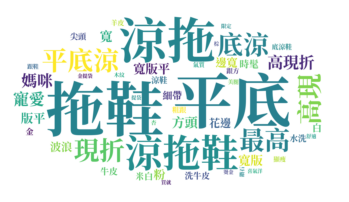

In [9]:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### ( 4 ) 以列表形式輸出

In [10]:
final1[final1['Rank']<10]

MemberId KeyWords   Count  Rank
0         zzzHm2cdbc30xk0pPbND0hTJC9KvNVW3vvOpTfzWsvo=       平底  246.66     0
1         zzzHm2cdbc30xk0pPbND0hTJC9KvNVW3vvOpTfzWsvo=       拖鞋  245.66     1
2         zzzHm2cdbc30xk0pPbND0hTJC9KvNVW3vvOpTfzWsvo=       涼拖  244.66     2
3         zzzHm2cdbc30xk0pPbND0hTJC9KvNVW3vvOpTfzWsvo=      涼拖鞋  244.66     3
4         zzzHm2cdbc30xk0pPbND0hTJC9KvNVW3vvOpTfzWsvo=      平底涼  238.66     4
...                                                ...      ...     ...   ...
10871458  ++/PaLQ2WfBYg+I9LFaid479crfYCwavoyPpb66WVE8=       增高  119.16     5
10871459  ++/PaLQ2WfBYg+I9LFaid479crfYCwavoyPpb66WVE8=       媽咪  119.16     6
10871460  ++/PaLQ2WfBYg+I9LFaid479crfYCwavoyPpb66WVE8=       寵愛  119.16     7
10871461  ++/PaLQ2WfBYg+I9LFaid479crfYCwavoyPpb66WVE8=       最高  119.16     8
10871462  ++/PaLQ2WfBYg+I9LFaid479crfYCwavoyPpb66WVE8=       現折  119.16     9

[2560438 rows x 4 columns]

--------------

## 四、會員分群

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from collections import Counter
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv(r'C:\Users\user\Desktop\大數據與商業分析\ba_final\member_weighted_less.csv', encoding='utf8')

In [4]:
df_run = df.drop(['Unnamed: 0'],axis=1)
df_run = df_run.set_index(['MemberId'])
df_run

高質感   粉嫩   長筒   水台   清新     皮平底  \
MemberId                                                                        
J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  0.0  0.0  0.0  0.0  0.0   29.25   
y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=  0.0  0.0  0.0  1.0  1.0    2.00   
YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=  0.0  0.0  0.0  0.0  7.0    1.00   
yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  0.0  0.0  0.0  1.0  0.0  111.75   
7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=  0.0  0.0  0.0  0.0  0.0    0.00   
...                                           ...  ...  ...  ...  ...     ...   
Yi5zpFHIpSpW18MNms47MTwdMH9YQDmejrLqtctjmKY=  0.0  0.0  0.0  0.0  0.0    0.00   
IaFeKVHj8fSVLY/8+/yxIUtzeTP5dn9Lu/MplZ7Ksfk=  0.0  0.0  0.0  0.0  0.0    0.00   
uG8VBBZe86lnvmGF8O3nXJuCr3pMmjzrUz67a/w7yIA=  0.0  0.0  0.0  0.0  0.0    0.00   
H1GvQoeUG1L5GF+2ipLgIDdYrtBlsSYkUVubiwr9zoY=  0.0  0.0  0.0  0.0  0.0    0.00   
Py4+OQ2VNuXgaUr5wbpPLU+4SNe9zHgtaSuDQhTzekQ=  0.0  0.0  0.0  0.0  0.0    0.00   

                                               姿態   帶過      個性   空繫  ...  \
MemberId                                                             ...   
J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  0.0  0.0    1.00  0.0  ...   
y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=  0.0  0.0    0.00  0.0  ...   
YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=  0.0  0.0  849.44  0.0  ...   
yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  0.0  0.0    6.00  0.0  ...   
7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=  0.0  0.0    0.00  0.0  ...   
...                                           ...  ...     ...  ...  ...   
Yi5zpFHIpSpW18MNms47MTwdMH9YQDmejrLqtctjmKY=  0.0  0.0    0.00  0.0  ...   
IaFeKVHj8fSVLY/8+/yxIUtzeTP5dn9Lu/MplZ7Ksfk=  0.0  0.0    0.00  0.0  ...   
uG8VBBZe86lnvmGF8O3nXJuCr3pMmjzrUz67a/w7yIA=  0.0  0.0    0.00  0.0  ...   
H1GvQoeUG1L5GF+2ipLgIDdYrtBlsSYkUVubiwr9zoY=  0.0  0.0    0.00  0.0  ...   
Py4+OQ2VNuXgaUr5wbpPLU+4SNe9zHgtaSuDQhTzekQ=  0.0  0.0    0.00  0.0  ...   

                                                掛飾  皮雪靴   腳窩   皮繫  香菱格   皮繩  \
MemberId                                                                      
J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=   0.0  2.0  0.0  0.0  0.0  0.0   
y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=   0.0  0.0  0.0  0.0  0.0  0.0   
YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=   1.0  0.0  0.0  0.0  0.0  0.0   
yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  39.5  1.0  0.0  1.0  0.0  0.0   
7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=   0.0  0.0  0.0  0.0  0.0  0.0   
...                                            ...  ...  ...  ...  ...  ...   
Yi5zpFHIpSpW18MNms47MTwdMH9YQDmejrLqtctjmKY=   0.0  0.0  0.0  0.0  0.0  0.0   
IaFeKVHj8fSVLY/8+/yxIUtzeTP5dn9Lu/MplZ7Ksfk=   0.0  0.0  0.0  0.0  0.0  0.0   
uG8VBBZe86lnvmGF8O3nXJuCr3pMmjzrUz67a/w7yIA=   0.0  0.0  0.0  0.0  0.0  0.0   
H1GvQoeUG1L5GF+2ipLgIDdYrtBlsSYkUVubiwr9zoY=   0.0  0.0  0.0  0.0  0.0  0.0   
Py4+OQ2VNuXgaUr5wbpPLU+4SNe9zHgtaSuDQhTzekQ=   0.0  0.0  0.0  0.0  0.0  0.0   

                                                 鹽系   俏皮   極度   夾包  
MemberId                                                            
J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  60.75  0.0  0.0  0.0  
y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=   1.00  0.0  2.0  0.0  
YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=   0.00  0.0  0.0  0.0  
yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=   5.00  0.0  3.0  3.0  
7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=   0.00  0.0  0.0  0.0  
...                                             ...  ...  ...  ...  
Yi5zpFHIpSpW18MNms47MTwdMH9YQDmejrLqtctjmKY=   0.00  0.0  0.0  0.0  
IaFeKVHj8fSVLY/8+/yxIUtzeTP5dn9Lu/MplZ7Ksfk=   0.00  0.0  0.0  0.0  
uG8VBBZe86lnvmGF8O3nXJuCr3pMmjzrUz67a/w7yIA=   0.00  0.0  0.0  0.0  
H1GvQoeUG1L5GF+2ipLgIDdYrtBlsSYkUVubiwr9zoY=   0.00  0.0  0.0  0.0  
Py4+OQ2VNuXgaUr5wbpPLU+4SNe9zHgtaSuDQhTzekQ=   0.00  0.0  0.0  0.0  

[257542 rows x 2054 columns]

In [5]:
df_run = df_run.astype(float)
df_run = df_run.fillna(0)
df_run

高質感   粉嫩   長筒   水台   清新     皮平底  \
MemberId                                                                        
J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  0.0  0.0  0.0  0.0  0.0   29.25   
y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=  0.0  0.0  0.0  1.0  1.0    2.00   
YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=  0.0  0.0  0.0  0.0  7.0    1.00   
yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  0.0  0.0  0.0  1.0  0.0  111.75   
7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=  0.0  0.0  0.0  0.0  0.0    0.00   
...                                           ...  ...  ...  ...  ...     ...   
Yi5zpFHIpSpW18MNms47MTwdMH9YQDmejrLqtctjmKY=  0.0  0.0  0.0  0.0  0.0    0.00   
IaFeKVHj8fSVLY/8+/yxIUtzeTP5dn9Lu/MplZ7Ksfk=  0.0  0.0  0.0  0.0  0.0    0.00   
uG8VBBZe86lnvmGF8O3nXJuCr3pMmjzrUz67a/w7yIA=  0.0  0.0  0.0  0.0  0.0    0.00   
H1GvQoeUG1L5GF+2ipLgIDdYrtBlsSYkUVubiwr9zoY=  0.0  0.0  0.0  0.0  0.0    0.00   
Py4+OQ2VNuXgaUr5wbpPLU+4SNe9zHgtaSuDQhTzekQ=  0.0  0.0  0.0  0.0  0.0    0.00   

                                               姿態   帶過      個性   空繫  ...  \
MemberId                                                             ...   
J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  0.0  0.0    1.00  0.0  ...   
y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=  0.0  0.0    0.00  0.0  ...   
YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=  0.0  0.0  849.44  0.0  ...   
yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  0.0  0.0    6.00  0.0  ...   
7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=  0.0  0.0    0.00  0.0  ...   
...                                           ...  ...     ...  ...  ...   
Yi5zpFHIpSpW18MNms47MTwdMH9YQDmejrLqtctjmKY=  0.0  0.0    0.00  0.0  ...   
IaFeKVHj8fSVLY/8+/yxIUtzeTP5dn9Lu/MplZ7Ksfk=  0.0  0.0    0.00  0.0  ...   
uG8VBBZe86lnvmGF8O3nXJuCr3pMmjzrUz67a/w7yIA=  0.0  0.0    0.00  0.0  ...   
H1GvQoeUG1L5GF+2ipLgIDdYrtBlsSYkUVubiwr9zoY=  0.0  0.0    0.00  0.0  ...   
Py4+OQ2VNuXgaUr5wbpPLU+4SNe9zHgtaSuDQhTzekQ=  0.0  0.0    0.00  0.0  ...   

                                                掛飾  皮雪靴   腳窩   皮繫  香菱格   皮繩  \
MemberId                                                                      
J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=   0.0  2.0  0.0  0.0  0.0  0.0   
y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=   0.0  0.0  0.0  0.0  0.0  0.0   
YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=   1.0  0.0  0.0  0.0  0.0  0.0   
yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  39.5  1.0  0.0  1.0  0.0  0.0   
7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=   0.0  0.0  0.0  0.0  0.0  0.0   
...                                            ...  ...  ...  ...  ...  ...   
Yi5zpFHIpSpW18MNms47MTwdMH9YQDmejrLqtctjmKY=   0.0  0.0  0.0  0.0  0.0  0.0   
IaFeKVHj8fSVLY/8+/yxIUtzeTP5dn9Lu/MplZ7Ksfk=   0.0  0.0  0.0  0.0  0.0  0.0   
uG8VBBZe86lnvmGF8O3nXJuCr3pMmjzrUz67a/w7yIA=   0.0  0.0  0.0  0.0  0.0  0.0   
H1GvQoeUG1L5GF+2ipLgIDdYrtBlsSYkUVubiwr9zoY=   0.0  0.0  0.0  0.0  0.0  0.0   
Py4+OQ2VNuXgaUr5wbpPLU+4SNe9zHgtaSuDQhTzekQ=   0.0  0.0  0.0  0.0  0.0  0.0   

                                                 鹽系   俏皮   極度   夾包  
MemberId                                                            
J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  60.75  0.0  0.0  0.0  
y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=   1.00  0.0  2.0  0.0  
YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=   0.00  0.0  0.0  0.0  
yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=   5.00  0.0  3.0  3.0  
7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=   0.00  0.0  0.0  0.0  
...                                             ...  ...  ...  ...  
Yi5zpFHIpSpW18MNms47MTwdMH9YQDmejrLqtctjmKY=   0.00  0.0  0.0  0.0  
IaFeKVHj8fSVLY/8+/yxIUtzeTP5dn9Lu/MplZ7Ksfk=   0.00  0.0  0.0  0.0  
uG8VBBZe86lnvmGF8O3nXJuCr3pMmjzrUz67a/w7yIA=   0.00  0.0  0.0  0.0  
H1GvQoeUG1L5GF+2ipLgIDdYrtBlsSYkUVubiwr9zoY=   0.00  0.0  0.0  0.0  
Py4+OQ2VNuXgaUr5wbpPLU+4SNe9zHgtaSuDQhTzekQ=   0.00  0.0  0.0  0.0  

[257542 rows x 2054 columns]

In [8]:
X = df_run[:100000]
X

高質感   粉嫩   長筒   水台   清新     皮平底  \
MemberId                                                                        
J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  0.0  0.0  0.0  0.0  0.0   29.25   
y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=  0.0  0.0  0.0  1.0  1.0    2.00   
YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=  0.0  0.0  0.0  0.0  7.0    1.00   
yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  0.0  0.0  0.0  1.0  0.0  111.75   
7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=  0.0  0.0  0.0  0.0  0.0    0.00   
...                                           ...  ...  ...  ...  ...     ...   
crvoBQa3wcY/ZWeEeQpyjLmxoKWiRt1OihnITEkOK10=  0.0  0.0  0.0  0.0  0.0    0.00   
4ekBuJfyOWfo8+hvwaABn51VHJ5uoxm9mtGPevqPY4s=  0.0  0.0  0.0  0.0  0.0    0.00   
R2Inw949d5Gt0ttm5BAE2KSMos8NqDlRTW9n7LvI+4U=  0.0  0.0  0.0  0.0  0.0    0.00   
gGQlAWxoRVb5X03oX2pAba/pQFURdtG1zckS42MSCOs=  0.0  0.0  0.0  0.0  0.0    0.00   
fgEcM8vn/iFxOBGzviiSqTqY+uCtE+iOi+h5MhkuZ9Y=  0.0  0.0  0.0  0.0  0.0    0.00   

                                               姿態   帶過      個性   空繫  ...  \
MemberId                                                             ...   
J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  0.0  0.0    1.00  0.0  ...   
y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=  0.0  0.0    0.00  0.0  ...   
YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=  0.0  0.0  849.44  0.0  ...   
yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  0.0  0.0    6.00  0.0  ...   
7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=  0.0  0.0    0.00  0.0  ...   
...                                           ...  ...     ...  ...  ...   
crvoBQa3wcY/ZWeEeQpyjLmxoKWiRt1OihnITEkOK10=  0.0  0.0    0.00  0.0  ...   
4ekBuJfyOWfo8+hvwaABn51VHJ5uoxm9mtGPevqPY4s=  0.0  0.0    0.00  0.0  ...   
R2Inw949d5Gt0ttm5BAE2KSMos8NqDlRTW9n7LvI+4U=  0.0  0.0    0.00  0.0  ...   
gGQlAWxoRVb5X03oX2pAba/pQFURdtG1zckS42MSCOs=  0.0  0.0    3.00  0.0  ...   
fgEcM8vn/iFxOBGzviiSqTqY+uCtE+iOi+h5MhkuZ9Y=  0.0  0.0    0.00  0.0  ...   

                                                掛飾     皮雪靴   腳窩   皮繫  香菱格  \
MemberId                                                                    
J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=   0.0    2.00  0.0  0.0  0.0   
y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=   0.0    0.00  0.0  0.0  0.0   
YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=   1.0    0.00  0.0  0.0  0.0   
yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  39.5    1.00  0.0  1.0  0.0   
7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=   0.0    0.00  0.0  0.0  0.0   
...                                            ...     ...  ...  ...  ...   
crvoBQa3wcY/ZWeEeQpyjLmxoKWiRt1OihnITEkOK10=   0.0  165.32  0.0  0.0  0.0   
4ekBuJfyOWfo8+hvwaABn51VHJ5uoxm9mtGPevqPY4s=   0.0    0.00  0.0  0.0  0.0   
R2Inw949d5Gt0ttm5BAE2KSMos8NqDlRTW9n7LvI+4U=   0.0    0.00  0.0  0.0  0.0   
gGQlAWxoRVb5X03oX2pAba/pQFURdtG1zckS42MSCOs=   0.0    1.00  0.0  0.0  0.0   
fgEcM8vn/iFxOBGzviiSqTqY+uCtE+iOi+h5MhkuZ9Y=   0.0    0.00  0.0  0.0  0.0   

                                               皮繩     鹽系   俏皮   極度   夾包  
MemberId                                                                 
J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  0.0  60.75  0.0  0.0  0.0  
y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=  0.0   1.00  0.0  2.0  0.0  
YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=  0.0   0.00  0.0  0.0  0.0  
yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  0.0   5.00  0.0  3.0  3.0  
7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=  0.0   0.00  0.0  0.0  0.0  
...                                           ...    ...  ...  ...  ...  
crvoBQa3wcY/ZWeEeQpyjLmxoKWiRt1OihnITEkOK10=  0.0   0.00  0.0  0.0  0.0  
4ekBuJfyOWfo8+hvwaABn51VHJ5uoxm9mtGPevqPY4s=  0.0   0.00  0.0  0.0  0.0  
R2Inw949d5Gt0ttm5BAE2KSMos8NqDlRTW9n7LvI+4U=  0.0   0.00  0.0  0.0  1.0  
gGQlAWxoRVb5X03oX2pAba/pQFURdtG1zckS42MSCOs=  0.0   0.00  0.0  0.0  0.0  
fgEcM8vn/iFxOBGzviiSqTqY+uCtE+iOi+h5MhkuZ9Y=  0.0   0.00  0.0  0.0  0.0  

[100000 rows x 2054 columns]

In [9]:
from sklearn.cluster import KMeans

In [11]:
# k = 1~9 做9次kmeans, 並將每次結果的inertia收集在一個list裡
kmeans_list = [KMeans(n_clusters=k, random_state=46).fit(X)
                for k in range(3, 11)]
distortions = [model.inertia_ for model in kmeans_list]

In [12]:
distortions #找到突然變小的數字的下一個作為n_clusters並替換到下面跑

[651073281123.2721,
 537467133067.131,
 481836513063.3297,
 443717770913.342,
 419038514834.76465,
 403147786482.9324,
 391894537306.23456,
 381532581239.60565]

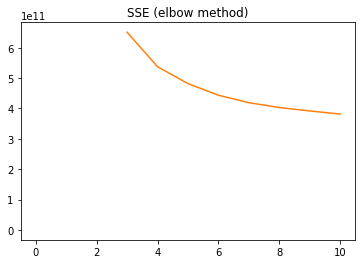

In [23]:
# 繪製誤差平方和圖 (手肘法)
k_range = range(3,11)
plt.plot(10000)
plt.title('SSE (elbow method)')
plt.plot(k_range, distortions)

In [26]:
X = df_run[:100000]
X

高質感   粉嫩   長筒   水台   清新     皮平底   姿態   帶過      個性   空繫  ...    掛飾  \
0      0.0  0.0  0.0  0.0  0.0   29.25  0.0  0.0    1.00  0.0  ...   0.0   
1      0.0  0.0  0.0  1.0  1.0    2.00  0.0  0.0    0.00  0.0  ...   0.0   
2      0.0  0.0  0.0  0.0  7.0    1.00  0.0  0.0  849.44  0.0  ...   1.0   
3      0.0  0.0  0.0  1.0  0.0  111.75  0.0  0.0    6.00  0.0  ...  39.5   
4      0.0  0.0  0.0  0.0  0.0    0.00  0.0  0.0    0.00  0.0  ...   0.0   
...    ...  ...  ...  ...  ...     ...  ...  ...     ...  ...  ...   ...   
99995  0.0  0.0  0.0  0.0  0.0    0.00  0.0  0.0    0.00  0.0  ...   0.0   
99996  0.0  0.0  0.0  0.0  0.0    0.00  0.0  0.0    0.00  0.0  ...   0.0   
99997  0.0  0.0  0.0  0.0  0.0    0.00  0.0  0.0    0.00  0.0  ...   0.0   
99998  0.0  0.0  0.0  0.0  0.0    0.00  0.0  0.0    3.00  0.0  ...   0.0   
99999  0.0  0.0  0.0  0.0  0.0    0.00  0.0  0.0    0.00  0.0  ...   0.0   

          皮雪靴   腳窩   皮繫  香菱格   皮繩     鹽系   俏皮   極度   夾包  
0        2.00  0.0  0.0  0.0  0.0  60.75  0.0  0.0  0.0  
1        0.00  0.0  0.0  0.0  0.0   1.00  0.0  2.0  0.0  
2        0.00  0.0  0.0  0.0  0.0   0.00  0.0  0.0  0.0  
3        1.00  0.0  1.0  0.0  0.0   5.00  0.0  3.0  3.0  
4        0.00  0.0  0.0  0.0  0.0   0.00  0.0  0.0  0.0  
...       ...  ...  ...  ...  ...    ...  ...  ...  ...  
99995  165.32  0.0  0.0  0.0  0.0   0.00  0.0  0.0  0.0  
99996    0.00  0.0  0.0  0.0  0.0   0.00  0.0  0.0  0.0  
99997    0.00  0.0  0.0  0.0  0.0   0.00  0.0  0.0  1.0  
99998    1.00  0.0  0.0  0.0  0.0   0.00  0.0  0.0  0.0  
99999    0.00  0.0  0.0  0.0  0.0   0.00  0.0  0.0  0.0  

[100000 rows x 2054 columns]

In [24]:
kmeansModel = KMeans(n_clusters=7, random_state=46) #n_clusters要換
clusters_pred = kmeansModel.fit_predict(X)

In [54]:
labels=kmeansModel.labels_
X['clusters_pred'] = labels
X

<ipython-input-54-50ad2e281a13>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['clusters_pred'] = labels


高質感   粉嫩   長筒   水台   清新     皮平底  \
MemberId                                                                        
J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  0.0  0.0  0.0  0.0  0.0   29.25   
y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=  0.0  0.0  0.0  1.0  1.0    2.00   
YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=  0.0  0.0  0.0  0.0  7.0    1.00   
yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  0.0  0.0  0.0  1.0  0.0  111.75   
7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=  0.0  0.0  0.0  0.0  0.0    0.00   
...                                           ...  ...  ...  ...  ...     ...   
crvoBQa3wcY/ZWeEeQpyjLmxoKWiRt1OihnITEkOK10=  0.0  0.0  0.0  0.0  0.0    0.00   
4ekBuJfyOWfo8+hvwaABn51VHJ5uoxm9mtGPevqPY4s=  0.0  0.0  0.0  0.0  0.0    0.00   
R2Inw949d5Gt0ttm5BAE2KSMos8NqDlRTW9n7LvI+4U=  0.0  0.0  0.0  0.0  0.0    0.00   
gGQlAWxoRVb5X03oX2pAba/pQFURdtG1zckS42MSCOs=  0.0  0.0  0.0  0.0  0.0    0.00   
fgEcM8vn/iFxOBGzviiSqTqY+uCtE+iOi+h5MhkuZ9Y=  0.0  0.0  0.0  0.0  0.0    0.00   

                                               姿態   帶過      個性   空繫  ...  \
MemberId                                                             ...   
J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  0.0  0.0    1.00  0.0  ...   
y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=  0.0  0.0    0.00  0.0  ...   
YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=  0.0  0.0  849.44  0.0  ...   
yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  0.0  0.0    6.00  0.0  ...   
7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=  0.0  0.0    0.00  0.0  ...   
...                                           ...  ...     ...  ...  ...   
crvoBQa3wcY/ZWeEeQpyjLmxoKWiRt1OihnITEkOK10=  0.0  0.0    0.00  0.0  ...   
4ekBuJfyOWfo8+hvwaABn51VHJ5uoxm9mtGPevqPY4s=  0.0  0.0    0.00  0.0  ...   
R2Inw949d5Gt0ttm5BAE2KSMos8NqDlRTW9n7LvI+4U=  0.0  0.0    0.00  0.0  ...   
gGQlAWxoRVb5X03oX2pAba/pQFURdtG1zckS42MSCOs=  0.0  0.0    3.00  0.0  ...   
fgEcM8vn/iFxOBGzviiSqTqY+uCtE+iOi+h5MhkuZ9Y=  0.0  0.0    0.00  0.0  ...   

                                                 皮雪靴   腳窩   皮繫  香菱格   皮繩  \
MemberId                                                                   
J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=    2.00  0.0  0.0  0.0  0.0   
y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=    0.00  0.0  0.0  0.0  0.0   
YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=    0.00  0.0  0.0  0.0  0.0   
yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=    1.00  0.0  1.0  0.0  0.0   
7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=    0.00  0.0  0.0  0.0  0.0   
...                                              ...  ...  ...  ...  ...   
crvoBQa3wcY/ZWeEeQpyjLmxoKWiRt1OihnITEkOK10=  165.32  0.0  0.0  0.0  0.0   
4ekBuJfyOWfo8+hvwaABn51VHJ5uoxm9mtGPevqPY4s=    0.00  0.0  0.0  0.0  0.0   
R2Inw949d5Gt0ttm5BAE2KSMos8NqDlRTW9n7LvI+4U=    0.00  0.0  0.0  0.0  0.0   
gGQlAWxoRVb5X03oX2pAba/pQFURdtG1zckS42MSCOs=    1.00  0.0  0.0  0.0  0.0   
fgEcM8vn/iFxOBGzviiSqTqY+uCtE+iOi+h5MhkuZ9Y=    0.00  0.0  0.0  0.0  0.0   

                                                 鹽系   俏皮   極度   夾包  \
MemberId                                                             
J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  60.75  0.0  0.0  0.0   
y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=   1.00  0.0  2.0  0.0   
YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=   0.00  0.0  0.0  0.0   
yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=   5.00  0.0  3.0  3.0   
7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=   0.00  0.0  0.0  0.0   
...                                             ...  ...  ...  ...   
crvoBQa3wcY/ZWeEeQpyjLmxoKWiRt1OihnITEkOK10=   0.00  0.0  0.0  0.0   
4ekBuJfyOWfo8+hvwaABn51VHJ5uoxm9mtGPevqPY4s=   0.00  0.0  0.0  0.0   
R2Inw949d5Gt0ttm5BAE2KSMos8NqDlRTW9n7LvI+4U=   0.00  0.0  0.0  1.0   
gGQlAWxoRVb5X03oX2pAba/pQFURdtG1zckS42MSCOs=   0.00  0.0  0.0  0.0   
fgEcM8vn/iFxOBGzviiSqTqY+uCtE+iOi+h5MhkuZ9Y=   0.00  0.0  0.0  0.0   

                                              clusters_pred  
MemberId                                 

In [31]:
set(clusters_pred)

{0, 1, 2, 3, 4, 5, 6}

In [25]:
kmeansModel.inertia_#計算各個樣本到該群的中心點的距離之平方和，用來評估集群的成效，其 inertia 越大代表越差

419038514834.76465

In [26]:
kmeansModel.cluster_centers_ #各群集的中心點

array([[  3.68322086,   2.34930982,   2.36743098, ...,   3.26348926,
         10.17880368,  33.10562117],
       [  0.27015257,   0.34427255,   0.47390869, ...,   0.67249007,
          1.53524901,   2.35735736],
       [ 29.10129412,   2.01764706,  18.45258824, ...,  22.96458824,
         26.852     , 124.55023529],
       ...,
       [  7.39705405,   3.35972973,   1.56689189, ...,   6.41194595,
         17.35532432,  64.45356757],
       [ 18.985     ,   1.91666667,  34.275     , ...,   5.85416667,
         61.05916667, 233.8675    ],
       [  0.85289732,   0.77200469,   0.91450362, ...,   1.36509161,
          4.22693651,   8.46353643]])

#### Visualization the clusters 

In [55]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
points = svd.fit_transform(X)
points[:20]

array([[ 6.98241288e+03, -4.82223094e+02],
       [ 1.67012129e+03, -2.50646194e+02],
       [ 5.36296499e+03, -7.51114723e+02],
       [ 1.12585218e+04,  1.77816166e+03],
       [ 2.14554712e+03, -3.28097571e+02],
       [ 1.85617196e+03,  1.03648757e+03],
       [ 1.62874582e+03, -4.49113068e+01],
       [ 1.21829946e+03, -6.06271542e+01],
       [ 1.18364698e+03, -2.60680704e+02],
       [ 1.84150293e+02, -3.99263739e+01],
       [ 4.90652271e+03, -8.08379261e+02],
       [ 4.50790726e+03, -8.69703538e+02],
       [ 9.31490976e+03,  7.03078553e+03],
       [ 1.52346746e+02, -6.19766057e+00],
       [ 1.46352130e+03,  2.78346266e+02],
       [ 9.36033831e+01,  7.80864482e+01],
       [ 4.62126493e+03, -1.13512849e+02],
       [ 1.24357763e+03, -7.43847475e+01],
       [ 1.35217467e+03, -1.12023595e+02],
       [ 3.54457906e+03, -3.18012652e+02]])

In [58]:
X = X.reset_index()
X

MemberId  高質感   粉嫩   長筒   水台   清新  \
0      J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  0.0  0.0  0.0  0.0  0.0   
1      y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=  0.0  0.0  0.0  1.0  1.0   
2      YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=  0.0  0.0  0.0  0.0  7.0   
3      yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  0.0  0.0  0.0  1.0  0.0   
4      7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=  0.0  0.0  0.0  0.0  0.0   
...                                             ...  ...  ...  ...  ...  ...   
99995  crvoBQa3wcY/ZWeEeQpyjLmxoKWiRt1OihnITEkOK10=  0.0  0.0  0.0  0.0  0.0   
99996  4ekBuJfyOWfo8+hvwaABn51VHJ5uoxm9mtGPevqPY4s=  0.0  0.0  0.0  0.0  0.0   
99997  R2Inw949d5Gt0ttm5BAE2KSMos8NqDlRTW9n7LvI+4U=  0.0  0.0  0.0  0.0  0.0   
99998  gGQlAWxoRVb5X03oX2pAba/pQFURdtG1zckS42MSCOs=  0.0  0.0  0.0  0.0  0.0   
99999  fgEcM8vn/iFxOBGzviiSqTqY+uCtE+iOi+h5MhkuZ9Y=  0.0  0.0  0.0  0.0  0.0   

          皮平底   姿態   帶過      個性  ...     皮雪靴   腳窩   皮繫  香菱格   皮繩     鹽系   俏皮  \
0       29.25  0.0  0.0    1.00  ...    2.00  0.0  0.0  0.0  0.0  60.75  0.0   
1        2.00  0.0  0.0    0.00  ...    0.00  0.0  0.0  0.0  0.0   1.00  0.0   
2        1.00  0.0  0.0  849.44  ...    0.00  0.0  0.0  0.0  0.0   0.00  0.0   
3      111.75  0.0  0.0    6.00  ...    1.00  0.0  1.0  0.0  0.0   5.00  0.0   
4        0.00  0.0  0.0    0.00  ...    0.00  0.0  0.0  0.0  0.0   0.00  0.0   
...       ...  ...  ...     ...  ...     ...  ...  ...  ...  ...    ...  ...   
99995    0.00  0.0  0.0    0.00  ...  165.32  0.0  0.0  0.0  0.0   0.00  0.0   
99996    0.00  0.0  0.0    0.00  ...    0.00  0.0  0.0  0.0  0.0   0.00  0.0   
99997    0.00  0.0  0.0    0.00  ...    0.00  0.0  0.0  0.0  0.0   0.00  0.0   
99998    0.00  0.0  0.0    3.00  ...    1.00  0.0  0.0  0.0  0.0   0.00  0.0   
99999    0.00  0.0  0.0    0.00  ...    0.00  0.0  0.0  0.0  0.0   0.00  0.0   

        極度   夾包  clusters_pred  
0      0.0  0.0              6  
1      2.0  0.0              1  
2      0.0  0.0              6  
3      3.0  3.0              0  
4      0.0  0.0              1  
...    ...  ...            ...  
99995  0.0  0.0              3  
99996  0.0  0.0              3  
99997  0.0  1.0              3  
99998  0.0  0.0              3  
99999  0.0  0.0              3  

[100000 rows x 2056 columns]

In [59]:
df_point = pd.DataFrame(points, columns = ['x', 'y'])
df_merge = pd.concat([X, df_point], axis='columns')
df_merge

MemberId  高質感   粉嫩   長筒   水台   清新  \
0      J59L62Ol2BfVVnXRWvMJLeNl8+aQmGsuN/LKwTK3uSk=  0.0  0.0  0.0  0.0  0.0   
1      y4/0qRwvou7bkxICRzyfowPSQh4eihJOTxmXwjYQyZA=  0.0  0.0  0.0  1.0  1.0   
2      YVpKb+eg7Yuq8vPw+QrEBDfhoVMGEYwixu/fECcRncM=  0.0  0.0  0.0  0.0  7.0   
3      yLIh4ydnhBCNr5imtXY2zFbBAMNjqQVbS0co8eU4bSE=  0.0  0.0  0.0  1.0  0.0   
4      7twb2RPuZq/6jnndj35f8uxYMLoImqo9Y4SONo8QPlk=  0.0  0.0  0.0  0.0  0.0   
...                                             ...  ...  ...  ...  ...  ...   
99995  crvoBQa3wcY/ZWeEeQpyjLmxoKWiRt1OihnITEkOK10=  0.0  0.0  0.0  0.0  0.0   
99996  4ekBuJfyOWfo8+hvwaABn51VHJ5uoxm9mtGPevqPY4s=  0.0  0.0  0.0  0.0  0.0   
99997  R2Inw949d5Gt0ttm5BAE2KSMos8NqDlRTW9n7LvI+4U=  0.0  0.0  0.0  0.0  0.0   
99998  gGQlAWxoRVb5X03oX2pAba/pQFURdtG1zckS42MSCOs=  0.0  0.0  0.0  0.0  0.0   
99999  fgEcM8vn/iFxOBGzviiSqTqY+uCtE+iOi+h5MhkuZ9Y=  0.0  0.0  0.0  0.0  0.0   

          皮平底   姿態   帶過      個性  ...   皮繫  香菱格   皮繩     鹽系   俏皮   極度   夾包  \
0       29.25  0.0  0.0    1.00  ...  0.0  0.0  0.0  60.75  0.0  0.0  0.0   
1        2.00  0.0  0.0    0.00  ...  0.0  0.0  0.0   1.00  0.0  2.0  0.0   
2        1.00  0.0  0.0  849.44  ...  0.0  0.0  0.0   0.00  0.0  0.0  0.0   
3      111.75  0.0  0.0    6.00  ...  1.0  0.0  0.0   5.00  0.0  3.0  3.0   
4        0.00  0.0  0.0    0.00  ...  0.0  0.0  0.0   0.00  0.0  0.0  0.0   
...       ...  ...  ...     ...  ...  ...  ...  ...    ...  ...  ...  ...   
99995    0.00  0.0  0.0    0.00  ...  0.0  0.0  0.0   0.00  0.0  0.0  0.0   
99996    0.00  0.0  0.0    0.00  ...  0.0  0.0  0.0   0.00  0.0  0.0  0.0   
99997    0.00  0.0  0.0    0.00  ...  0.0  0.0  0.0   0.00  0.0  0.0  1.0   
99998    0.00  0.0  0.0    3.00  ...  0.0  0.0  0.0   0.00  0.0  0.0  0.0   
99999    0.00  0.0  0.0    0.00  ...  0.0  0.0  0.0   0.00  0.0  0.0  0.0   

       clusters_pred             x            y  
0                  6   6982.412879  -482.223094  
1                  1   1670.121293  -250.646194  
2                  6   5362.964987  -751.114723  
3                  0  11258.521778  1778.161659  
4                  1   2145.547125  -328.097571  
...              ...           ...          ...  
99995              3    125.325806     7.026491  
99996              3    236.278531    18.131129  
99997              3    482.331886   -19.235725  
99998              3    268.664050   -55.798174  
99999              3    255.250079   -54.033793  

[100000 rows x 2058 columns]

In [61]:
from bokeh.models import ColumnDataSource, Label, LabelSet, Range1d
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook

output_notebook()

def generate_color(x, total):
    def color_red_blue(ctr, reverse=False):
        r = int(ctr*255)
        b = 255-int(ctr*255)
        if reverse:
            return "#%02x%02x%02x" % (b, 0, r)
        else:
            return "#%02x%02x%02x" % (r, 0, b)
    return color_red_blue(x/total)

print(generate_color(1, 6))

Loading BokehJS ...

#2a00d5


In [66]:
p = figure(title = "Customer cluster")


colors = df_merge['clusters_pred'].apply(lambda x:generate_color(x, 7))

from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis, d3
palletes = d3['Category20'][7]
colors = [palletes[clu] for clu in df_merge['clusters_pred']]
# print(colors)
p.circle(df_merge["x"], df_merge["y"], color = colors, fill_alpha=0.2, size=10)
show(p) 

# 分群圖表需輸出為 html 才可見，展示於簡報 p.18